# 实验三

1. 认真阅读三篇文献资料（自己也可以下载相关文献进行阅读），了解资产定价模型的相关研究，重点关注其中的研究思路和方法。

2. 任意选取七个行业指数，从锐思数据库或tushare数据库，下载这些指数的周度数据和三因子的周度数据，估计FF三因子模型参数，并逐个行业检验其是否满足FF三因子模型；再对七个行业进行FF三因子模型的多资产检验。（月度数据不少于10年，周度数据不少于5年）

3. 从锐思数据库或tushare数据库，提取中国股市2004-2023年所有股票的月收益率、月流通市值数据、月市盈率数据，观察和研究课本P52页表格3-6的计算方法，计算先按市值再按盈利价格比（市盈率倒数）序贯排序的资产组合月平均收益率（注意：变量排序分成5组，不需要分成10组），并对结果进行讨论。

4. 从锐思数据库或tushare数据库，提取中国股市2004-2023年所有股票的月收益率、月流通市值数据、月市盈率数据、月CAPM风险因子Beta数据，请利用Fama-MacBeth回归检验市值、盈利价格比（市盈率倒数）、CAPM风险因子Beta对收益率的解释性。

## 七个行业指数

| 行业代码 | 行业名称 | 指数代码 |
|----------|----------|----------|
| 银行行业 | 银行 | 801780.SI |
| 化工行业 | 化工 | 801030.SI |
| 钢铁行业 | 钢铁 | 801040.SI |
| 有色金属行业 | 有色金属 | 801050.SI |
| 建筑材料行业 | 建筑材料 | 801710.SI |
| 电气设备行业 | 电气设备 | 801730.SI |
| 医药生物行业 | 医药生物 | 801150.SI |

### 逐个行业检验是否满足FF三因子

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tushare as ts
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 画图设置
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False 

# 设置Tushare token
ts.set_token('2207b01a244311f7742512463d9e1588954d174b86d695f8a9f1cc4b')
pro = ts.pro_api()

# 定义七个申万行业指数代码
industry_list = {
    '银行': '801780',     
    '化工': '801030',     
    '钢铁': '801040',
    '有色金属': '801050',  
    '建筑材料': '801710', 
    '电气设备': '801730', 
    '医药生物': '801150'
}

# 定义起止时间
end_date = '20171231'
start_date = '20090101'

In [2]:
# 获取申万行业成分股
def get_sw_industry_stocks(industry_code):
    try:
        # 添加.SI后缀用于API调用
        sw_code = f"{industry_code}.SI"
        df = pro.index_member_all(l1_code=sw_code)
        
        if df.empty:
            print(f"无法获取行业 {industry_code} 的成分股，尝试获取子行业成分股")
            # 尝试获取该行业的二级行业
            sub_industries = pro.index_classify(index_code=sw_code, level='L2')
            
            stocks = []
            for _, row in sub_industries.iterrows():
                sub_code = row['industry_code']
                sub_df = pro.index_member_all(l2_code=sub_code)
                if not sub_df.empty:
                    stocks.extend(sub_df['ts_code'].tolist())
            
            if not stocks:
                print(f"无法获取行业 {industry_code} 的任何成分股")
                return []
                
            return list(set(stocks))  # 去重
        else:
            return df['ts_code'].tolist()
    except Exception as e:
        print(f"获取行业 {industry_code} 成分股时出错: {e}")
        return []

In [3]:
# 获取行业周收益率（基于成分股）
def calculate_industry_return(industry_code, start_date, end_date):
    """
    基于行业成分股计算行业周收益率
    """
    # 获取行业成分股
    stocks = get_sw_industry_stocks(industry_code)
    
    if not stocks:
        print(f"行业 {industry_code} 没有有效的成分股")
        return None
    
    print(f"行业 {industry_code} 有 {len(stocks)} 只成分股")
    
    # 限制股票数量，防止API调用过多
    if len(stocks) > 50:
        # 随机选择50只股票
        np.random.seed(42)
        stocks = np.random.choice(stocks, 50, replace=False).tolist()
        print(f"随机选择了 50 只股票进行计算")
    
    # 获取所有股票的周收益率
    all_stocks_weekly = []
    
    for stock in stocks:
        try:
            # 获取股票周线数据
            stock_weekly = pro.weekly(ts_code=stock, start_date=start_date, end_date=end_date, 
                                    fields='ts_code,trade_date,close')
            
            if stock_weekly.empty:
                continue
                
            # 处理日期和计算收益率
            stock_weekly['trade_date'] = pd.to_datetime(stock_weekly['trade_date'])
            stock_weekly = stock_weekly.sort_values('trade_date')
            stock_weekly['return'] = stock_weekly['close'].pct_change()
            stock_weekly = stock_weekly.dropna()
            
            if not stock_weekly.empty:
                all_stocks_weekly.append(stock_weekly[['trade_date', 'return']].set_index('trade_date'))
        except Exception as e:
            print(f"获取股票 {stock} 数据出错: {e}")
            continue
    
    if not all_stocks_weekly:
        print(f"行业 {industry_code} 没有有效的股票收益率数据")
        return None
    
    # 合并所有股票的周收益率并计算行业平均收益率
    try:
        all_returns = pd.concat(all_stocks_weekly, axis=1)
        industry_weekly_return = all_returns.mean(axis=1)
        
        print(f"成功计算行业 {industry_code} 的周收益率, 共 {len(industry_weekly_return)} 个数据点")
        return industry_weekly_return
    except Exception as e:
        print(f"计算行业 {industry_code} 收益率时出错: {e}")
        return None

In [4]:
# 加载无风险利率，由于只有月度数据，这里直接简化除以4得到周度收益率
def load_rf_rate(file_path):
    rf_data = pd.read_csv(file_path, encoding='gbk')
    
    # 转换日期列为日期类型
    rf_data['日期_Date'] = pd.to_datetime(rf_data['日期_Date'])
    
    # 将数据设置为以日期为索引的Series
    rf_monthly = pd.Series(rf_data['月无风险收益率_MonRFRet'].values, index=rf_data['日期_Date'])
    
    # 将月度数据重采样为周度数据(使用前向填充)
    rf_weekly = rf_monthly.resample('W-FRI').ffill() / 4  # 将月收益率除以4估算为周收益率
    
    return rf_weekly

In [5]:
def calculate_factors(start_date, end_date):
    """
    计算三因子数据，包括市场风险溢价、SMB和HML
    """
    print("开始计算三因子数据...")
    
    # 1. 获取市场指数数据作为市场收益率（使用沪深300指数）
    print("获取市场指数数据...")
    market_df = pro.index_daily(ts_code='000300.SH', start_date=start_date, end_date=end_date)
    market_df['trade_date'] = pd.to_datetime(market_df['trade_date'])
    market_df = market_df.sort_values('trade_date')
    market_df = market_df.set_index('trade_date')
    market_weekly = market_df['close'].resample('W-FRI').last().dropna()
    market_return = market_weekly.pct_change().dropna()
    
    # 2. 生成用于计算SMB和HML的日期列表（每季度一次）
    portfolio_dates = pd.date_range(start=pd.to_datetime(start_date), 
                                   end=pd.to_datetime(end_date), 
                                   freq='Q').strftime('%Y%m%d').tolist()
    
    # 3. 初始化因子数据框
    factors_weekly = pd.DataFrame(index=market_return.index)
    factors_weekly['SMB'] = np.nan
    factors_weekly['HML'] = np.nan
    
    # 4. 计算每个日期的SMB和HML因子
    for date in portfolio_dates:
        print(f"计算 {date} 的SMB和HML因子...")
        
        # 获取当日所有股票的市值和PB数据
        try:
            daily_basic = pro.daily_basic(trade_date=date, fields='ts_code,total_mv,pb,close')
            if daily_basic.empty:
                print(f"日期 {date} 没有数据，跳过")
                continue
        except Exception as e:
            print(f"获取 {date} 基础数据出错: {e}")
            continue
        
        # 过滤掉PB为负或为0的股票
        daily_basic = daily_basic[daily_basic['pb'] > 0]
        
        # 按市值分为大小两组
        daily_basic['size_group'] = pd.qcut(daily_basic['total_mv'], q=2, labels=['small', 'big'])
        
        # 按PB倒数(B/M)分为三组
        daily_basic['bm'] = 1 / daily_basic['pb']  # 计算B/M比率
        daily_basic['bm_group'] = pd.qcut(daily_basic['bm'], q=3, labels=['low', 'medium', 'high'])
        
        # 形成六个投资组合
        portfolio_groups = {}
        for size in ['small', 'big']:
            for bm in ['low', 'medium', 'high']:
                portfolio_groups[f"{size}_{bm}"] = daily_basic[
                    (daily_basic['size_group'] == size) & 
                    (daily_basic['bm_group'] == bm)]['ts_code'].tolist()
        
        # 计算每个投资组合的周度收益率
        portfolio_returns = {}
        
        for port_name, stocks in portfolio_groups.items():
            if not stocks:
                portfolio_returns[port_name] = 0
                continue
            
            # 限制股票数量
            sample_stocks = stocks[:20] if len(stocks) > 20 else stocks
            
            # 计算投资组合收益率
            port_returns = []
            for stock in sample_stocks:
                try:
                    # 获取股票周线数据
                    stock_weekly = pro.weekly(ts_code=stock, start_date=date, 
                                             end_date=end_date, fields='ts_code,trade_date,close')
                    
                    if not stock_weekly.empty and len(stock_weekly) > 1:
                        stock_weekly['trade_date'] = pd.to_datetime(stock_weekly['trade_date'])
                        stock_weekly = stock_weekly.sort_values('trade_date')
                        stock_weekly['return'] = stock_weekly['close'].pct_change()
                        stock_weekly = stock_weekly.dropna()
                        
                        if not stock_weekly.empty:
                            port_returns.append(stock_weekly[['trade_date', 'return']].set_index('trade_date'))
                except:
                    continue
            
            if port_returns:
                try:
                    # 合并投资组合收益率
                    all_returns = pd.concat(port_returns, axis=1)
                    portfolio_weekly_return = all_returns.mean(axis=1)
                    
                    # 将投资组合收益率添加到factors_weekly
                    for week_date, ret in portfolio_weekly_return.items():
                        # 找到最近的周五
                        friday = week_date + pd.Timedelta(days=(4 - week_date.weekday()) % 7)
                        if friday in factors_weekly.index:
                            if port_name not in factors_weekly.columns:
                                factors_weekly[port_name] = np.nan
                            factors_weekly.loc[friday, port_name] = ret
                except Exception as e:
                    print(f"处理投资组合 {port_name} 时出错: {e}")
                    continue
    
    # 5. 计算SMB和HML因子
    for idx in factors_weekly.index:
        # 检查是否有所有需要的投资组合数据
        port_names = ['small_low', 'small_medium', 'small_high', 'big_low', 'big_medium', 'big_high']
        if all(port in factors_weekly.columns for port in port_names):
            try:
                # 计算SMB
                small_avg = (factors_weekly.loc[idx, 'small_low'] + 
                            factors_weekly.loc[idx, 'small_medium'] + 
                            factors_weekly.loc[idx, 'small_high']) / 3
                
                big_avg = (factors_weekly.loc[idx, 'big_low'] + 
                          factors_weekly.loc[idx, 'big_medium'] + 
                          factors_weekly.loc[idx, 'big_high']) / 3
                
                factors_weekly.loc[idx, 'SMB'] = small_avg - big_avg
                
                # 计算HML
                high_avg = (factors_weekly.loc[idx, 'small_high'] + 
                           factors_weekly.loc[idx, 'big_high']) / 2
                
                low_avg = (factors_weekly.loc[idx, 'small_low'] + 
                          factors_weekly.loc[idx, 'big_low']) / 2
                
                factors_weekly.loc[idx, 'HML'] = high_avg - low_avg
            except:
                continue
    
    # 6. 设置无风险利率
    rf_weekly = load_rf_rate('./assets/data/course/Data_RiskFreeReturn.csv')
    
    # 7. 最终数据整合
    final_factors = pd.DataFrame({
        'MKT': market_return,
        'SMB': factors_weekly['SMB'],
        'HML': factors_weekly['HML'],
        'RF': rf_weekly
    })
    
    # 使用前向填充处理缺失值
    final_factors = final_factors.fillna(method='ffill').dropna()
    
    print("三因子数据计算完成")
    return final_factors

In [6]:
def calculate_t_statistic(results):
    """
    计算t检验统计量
    """
    # 获取参数估计值
    params = results.params
    
    # 获取标准误差
    std_errors = results.bse
    
    # 计算t统计量
    t_stats = params / std_errors
    
    # 获取p值
    p_values = results.pvalues
    
    return pd.DataFrame({
        'coef': params,
        't_stat': t_stats,
        'p_value': p_values,
        'significance': ['***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else '' for p in p_values]
    })

In [7]:
def test_ff_model(results):
    """
    对模型进行检验，判断是否满足FF三因子模型
    """
    # 检验截距项是否为0
    alpha = results.params['const']
    alpha_pvalue = results.pvalues['const']
    
    # R方值
    r_squared = results.rsquared
    adj_r_squared = results.rsquared_adj
    
    # F检验
    f_stat = results.fvalue
    f_pvalue = results.f_pvalue
    
    # 判断是否满足三因子模型
    alpha_significant = alpha_pvalue < 0.05
    model_significant = f_pvalue < 0.05
    
    # 检验结果
    if not alpha_significant and model_significant:
        conclusion = "满足FF三因子模型，α不显著，模型整体显著"
    elif alpha_significant and model_significant:
        conclusion = "不完全满足FF三因子模型，α显著，模型整体显著"
    elif not alpha_significant and not model_significant:
        conclusion = "不满足FF三因子模型，α不显著，但模型整体不显著"
    else:
        conclusion = "不满足FF三因子模型，α显著，模型整体不显著"
    
    test_results = {
        'alpha': alpha,
        'alpha_pvalue': alpha_pvalue,
        'r_squared': r_squared,
        'adj_r_squared': adj_r_squared,
        'f_stat': f_stat,
        'f_pvalue': f_pvalue,
        'conclusion': conclusion
    }
    
    return test_results

In [8]:
def visualize_results(all_results, test_conclusions):
    """
    可视化FF三因子模型估计结果
    """
    if not all_results:
        print("没有有效的结果可视化")
        return
        
    # 设置风格
    plt.style.use('ggplot')
    
    # 1. 绘制各行业系数热力图
    plt.figure(figsize=(12, 8))
    
    # 提取系数
    coef_data = {}
    for industry, stats in all_results.items():
        coef_data[industry] = stats['coef']
    
    coef_df = pd.DataFrame(coef_data).T
    
    # 绘制热力图
    sns.heatmap(coef_df, annot=True, fmt=".4f", cmap="coolwarm", center=0,
                linewidths=.5, cbar_kws={"shrink": .8})
    
    plt.title('FF三因子模型系数估计结果', fontsize=15)
    plt.tight_layout()
    plt.show()
    
    # 2. 绘制R方对比条形图
    plt.figure(figsize=(10, 6))
    
    r_squared_data = {industry: result['r_squared'] for industry, result in test_conclusions.items()}
    industries = list(r_squared_data.keys())
    r_squared_values = list(r_squared_data.values())
    
    bars = plt.bar(industries, r_squared_values, color='skyblue')
    
    # 为柱状图添加数据标签
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', rotation=0)
    
    plt.xlabel('行业')
    plt.ylabel('R方值')
    plt.title('各行业FF三因子模型R方对比')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 3. 绘制因子载荷对比图
    plt.figure(figsize=(12, 8))
    
    # 提取MKT, SMB, HML系数
    factor_data = {
        'MKT': [stats['coef']['MKT'] for industry, stats in all_results.items()],
        'SMB': [stats['coef']['SMB'] for industry, stats in all_results.items()],
        'HML': [stats['coef']['HML'] for industry, stats in all_results.items()]
    }
    
    x = np.arange(len(industries))
    width = 0.25
    
    plt.bar(x - width, factor_data['MKT'], width, label='MKT', color='#1f77b4')
    plt.bar(x, factor_data['SMB'], width, label='SMB', color='#ff7f0e')
    plt.bar(x + width, factor_data['HML'], width, label='HML', color='#2ca02c')
    
    plt.xlabel('行业')
    plt.ylabel('因子载荷')
    plt.title('各行业FF三因子载荷对比')
    plt.xticks(x, industries, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

计算三因子数据...
开始计算三因子数据...
获取市场指数数据...
计算 20090331 的SMB和HML因子...
计算 20090630 的SMB和HML因子...
计算 20090930 的SMB和HML因子...
计算 20091231 的SMB和HML因子...
计算 20100331 的SMB和HML因子...
计算 20100630 的SMB和HML因子...
计算 20100930 的SMB和HML因子...
计算 20101231 的SMB和HML因子...
计算 20110331 的SMB和HML因子...
计算 20110630 的SMB和HML因子...
计算 20110930 的SMB和HML因子...
计算 20111231 的SMB和HML因子...
日期 20111231 没有数据，跳过
计算 20120331 的SMB和HML因子...
日期 20120331 没有数据，跳过
计算 20120630 的SMB和HML因子...
日期 20120630 没有数据，跳过
计算 20120930 的SMB和HML因子...
日期 20120930 没有数据，跳过
计算 20121231 的SMB和HML因子...
计算 20130331 的SMB和HML因子...
日期 20130331 没有数据，跳过
计算 20130630 的SMB和HML因子...
日期 20130630 没有数据，跳过
计算 20130930 的SMB和HML因子...
计算 20131231 的SMB和HML因子...
计算 20140331 的SMB和HML因子...
计算 20140630 的SMB和HML因子...
计算 20140930 的SMB和HML因子...
计算 20141231 的SMB和HML因子...
计算 20150331 的SMB和HML因子...
计算 20150630 的SMB和HML因子...
计算 20150930 的SMB和HML因子...
计算 20151231 的SMB和HML因子...
计算 20160331 的SMB和HML因子...
计算 20160630 的SMB和HML因子...
计算 20160930 的SMB和HML因子...
计算 20161231 的SMB和HML因子...
日期 20161231 

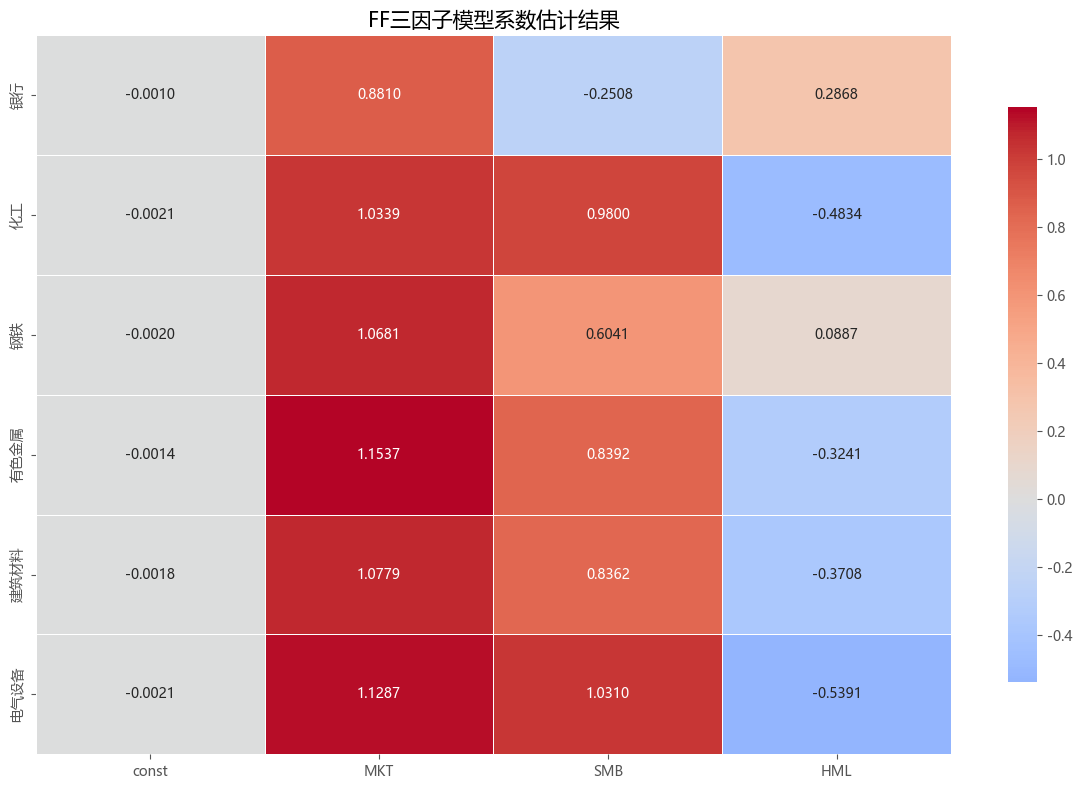

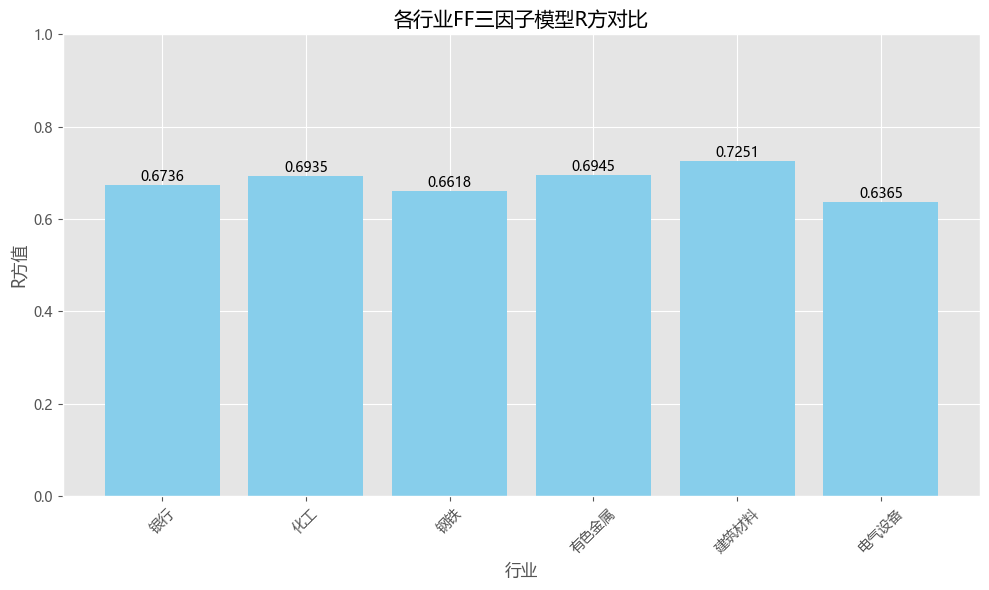

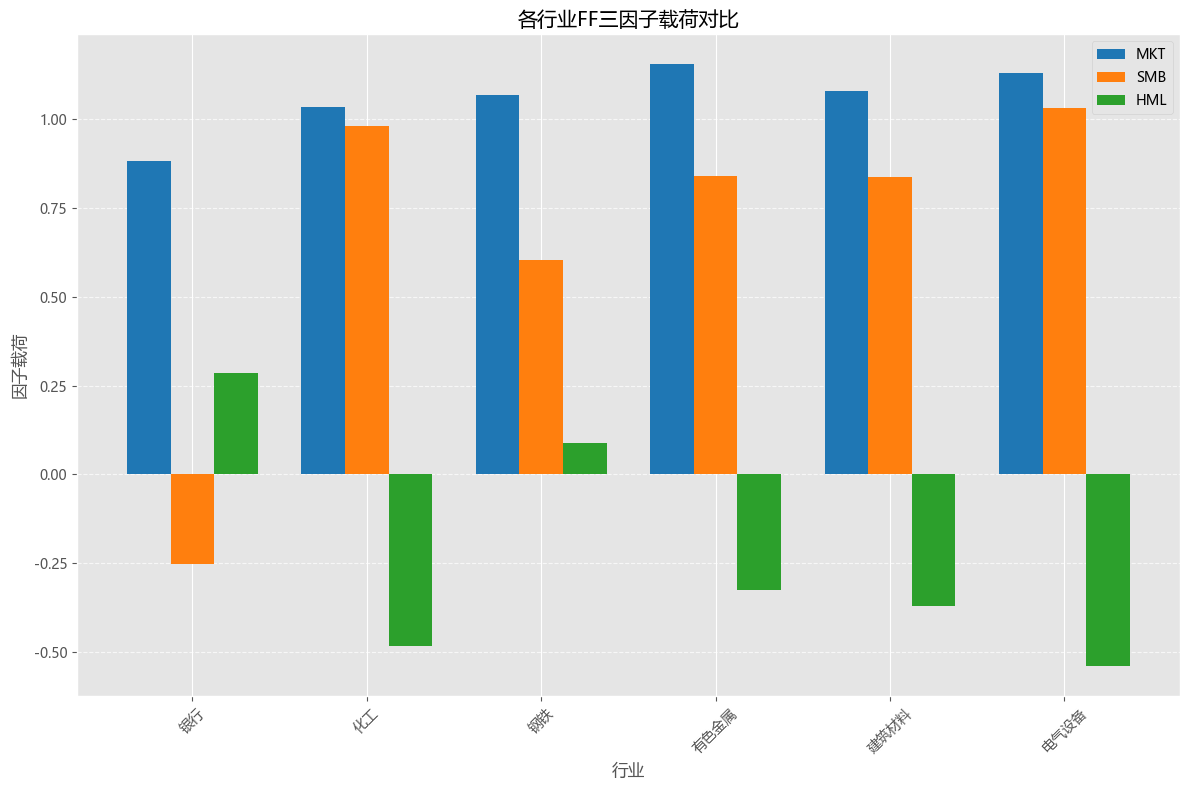

In [9]:
# 1. 获取三因子数据
print("计算三因子数据...")
factors = calculate_factors(start_date, end_date)

# 2. 计算行业收益率
industry_returns = {}
print("\n计算各行业收益率...")

for industry_name, industry_code in industry_list.items():
    print(f"\n处理 {industry_name} 行业...")
    
    # 计算行业收益率
    returns = calculate_industry_return(industry_code, start_date, end_date)
    if returns is not None:
        industry_returns[industry_name] = returns

# 3. 估计FF三因子模型参数
print("\n开始估计各行业的FF三因子模型...")

all_results = {}
test_conclusions = {}

for industry_name, returns in industry_returns.items():
    print(f"\n处理 {industry_name} 行业...")
    
    # 估计模型
    try:
        # 确保数据对齐
        aligned_data = pd.concat([returns, factors], axis=1, join='inner').dropna()
        
        # 计算超额收益率
        excess_returns = aligned_data.iloc[:, 0] - aligned_data['RF']
        
        # 准备自变量
        X = aligned_data[['MKT', 'SMB', 'HML']]
        X = sm.add_constant(X)
        
        # 运行OLS回归
        model = sm.OLS(excess_returns, X)
        results = model.fit()
        
        # 计算t统计量
        t_stats = calculate_t_statistic(results)
        
        # 模型检验
        test_result = test_ff_model(results)
        
        # 存储结果
        all_results[industry_name] = t_stats
        test_conclusions[industry_name] = test_result
        
        print(f"模型估计完成：{test_result['conclusion']}")
    except Exception as e:
        print(f"模型估计失败: {e}")

# 4. 输出汇总结果
print("\n==== FF三因子模型估计结果汇总 ====")
for industry, result in all_results.items():
    print(f"\n{industry}行业:")
    print(result)
    print(f"R方: {test_conclusions[industry]['r_squared']:.4f}")
    print(f"调整R方: {test_conclusions[industry]['adj_r_squared']:.4f}")
    print(f"F统计量: {test_conclusions[industry]['f_stat']:.4f} (p值: {test_conclusions[industry]['f_pvalue']:.4f})")
    print(f"结论: {test_conclusions[industry]['conclusion']}")

# 5. 可视化结果
visualize_results(all_results, test_conclusions)

### 对七个行业进行FF三因子模型的多资产检验

思路和上次实验差不多

In [10]:
def multi_asset_ff_test(industry_returns, factors):
    """
    对多个资产同时进行FF三因子模型检验
    
    参数:
    industry_returns (dict): 键为行业名称，值为收益率序列的字典
    factors (DataFrame): 三因子数据框，包含MKT、SMB、HML和RF列
    
    返回:
    tuple: (联合检验结果, 单个资产检验结果)
    """
    from scipy import stats
    
    print("\n===== 开始进行多资产FF三因子模型检验 =====")
    
    # 存储所有行业的回归结果
    all_results = {}
    all_params = {}
    all_residuals = {}
    
    N = len(industry_returns)  # 资产数量
    
    # 1. 对每个行业单独进行OLS估计，获取各自的alpha和beta
    print(f"\n1. 对{N}个行业进行单独OLS估计...")
    
    for industry, returns in industry_returns.items():
        # 确保数据对齐
        aligned_data = pd.concat([returns, factors], axis=1, join='inner').dropna()
        if len(aligned_data) == 0:
            print(f"警告: {industry}行业数据对齐后为空，跳过")
            continue
            
        # 计算超额收益率
        excess_returns = aligned_data.iloc[:, 0] - aligned_data['RF']
        
        # 准备自变量
        X = aligned_data[['MKT', 'SMB', 'HML']]
        X = sm.add_constant(X)
        
        # 运行OLS回归
        model = sm.OLS(excess_returns, X)
        results = model.fit()
        
        # 存储结果
        all_results[industry] = results
        all_params[industry] = results.params
        all_residuals[industry] = results.resid
    
    if len(all_results) == 0:
        print("没有有效的行业数据进行分析")
        return None, None
    
    # 2. 联合检验: H0: α1 = α2 = ... = αN = 0
    print("\n2. 进行联合检验 H0: α1 = α2 = ... = αN = 0")
    
    # 提取所有行业的alpha值
    alphas = np.array([params['const'] for params in all_params.values()])
    
    # 计算残差的协方差矩阵
    T = len(next(iter(all_residuals.values())))  # 样本数
    residuals_df = pd.DataFrame(all_residuals)
    Sigma = residuals_df.cov()  # 残差协方差矩阵
    
    # 根据图片中的GRS检验公式计算检验统计量
    try:
        # 计算均值μ
        mu_k = np.array([factors['MKT'].mean(), factors['SMB'].mean(), factors['HML'].mean()])
        
        # 计算因子协方差矩阵Ω
        factor_data = factors[['MKT', 'SMB', 'HML']]
        Omega = factor_data.cov()
        
        # 计算GRS统计量
        # S_GRS = ((T - N - K) / N) * (1 + μ'Ω^(-1)μ)^(-1) * α'Σ^(-1)α
        K = 3  # 三个因子
        
        # 计算 μ'Ω^(-1)μ
        Omega_inv = np.linalg.inv(Omega)
        mu_Omega_inv_mu = np.dot(np.dot(mu_k, Omega_inv), mu_k)
        
        # 计算 α'Σ^(-1)α
        Sigma_inv = np.linalg.inv(Sigma)
        alpha_Sigma_inv_alpha = np.dot(np.dot(alphas, Sigma_inv), alphas)
        
        # 计算GRS统计量
        GRS_stat = ((T - N - K) / N) * (1 + mu_Omega_inv_mu)**(-1) * alpha_Sigma_inv_alpha
        
        # 计算p值 (GRS统计量服从F分布，自由度为N和T-N-K)
        p_value = 1 - stats.f.cdf(GRS_stat, N, T - N - K)
        
        print(f"GRS统计量: {GRS_stat:.4f}")
        print(f"p值: {p_value:.4f}")
        
        if p_value < 0.05:
            print("结论: 在5%显著性水平下，拒绝所有alpha为0的原假设，FF三因子模型不能完全解释这些行业的收益率")
        else:
            print("结论: 在5%显著性水平下，不能拒绝所有alpha为0的原假设，FF三因子模型能够解释这些行业的收益率")
            
        joint_test_result = {
            'GRS_stat': GRS_stat,
            'p_value': p_value,
            'significance_level': 0.05,
            'reject_H0': p_value < 0.05,
            'N': N,
            'T': T,
            'K': K
        }
    except Exception as e:
        print(f"计算GRS统计量时出错: {e}")
        joint_test_result = None
    
    # 3. 单个资产检验结果汇总
    print("\n3. 单个资产检验结果汇总:")
    
    individual_results = {}
    for industry, results in all_results.items():
        alpha = results.params['const']
        alpha_tstat = results.tvalues['const']
        alpha_pvalue = results.pvalues['const']
        
        beta_mkt = results.params['MKT']
        beta_smb = results.params['SMB']
        beta_hml = results.params['HML']
        
        r_squared = results.rsquared
        adj_r_squared = results.rsquared_adj
        
        individual_results[industry] = {
            'alpha': alpha,
            'alpha_tstat': alpha_tstat,
            'alpha_pvalue': alpha_pvalue,
            'beta_mkt': beta_mkt,
            'beta_smb': beta_smb,
            'beta_hml': beta_hml,
            'r_squared': r_squared,
            'adj_r_squared': adj_r_squared,
            'reject_alpha_zero': alpha_pvalue < 0.05
        }
        
        print(f"\n{industry}行业:")
        print(f"α = {alpha:.6f} (t统计量: {alpha_tstat:.4f}, p值: {alpha_pvalue:.4f})")
        print(f"β_MKT = {beta_mkt:.4f}, β_SMB = {beta_smb:.4f}, β_HML = {beta_hml:.4f}")
        print(f"R² = {r_squared:.4f}, 调整R² = {adj_r_squared:.4f}")
        print(f"结论: {'拒绝' if alpha_pvalue < 0.05 else '不能拒绝'} α=0的假设")
    
    print("\n===== 多资产FF三因子模型检验完成 =====")
    
    return joint_test_result, individual_results

In [11]:
def visualize_multi_asset_test(joint_test, individual_results):
    """
    可视化多资产FF三因子模型检验结果
    """
    if joint_test is None or individual_results is None:
        print("没有有效的检验结果可视化")
        return
    
    # 设置风格
    plt.style.use('ggplot')
    
    # 1. 可视化各行业的alpha值及其置信区间
    plt.figure(figsize=(12, 6))
    
    industries = list(individual_results.keys())
    alphas = [res['alpha'] for res in individual_results.values()]
    alpha_tstats = [res['alpha_tstat'] for res in individual_results.values()]
    
    # 计算95%置信区间
    alpha_ci = [abs(1.96 * alpha / tstat) if tstat != 0 else 0 for alpha, tstat in zip(alphas, alpha_tstats)]
    
    # 绘制alpha值及其置信区间
    plt.errorbar(industries, alphas, yerr=alpha_ci, fmt='o', capsize=5, ecolor='red', color='blue')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    plt.title('各行业Alpha值及95%置信区间', fontsize=15)
    plt.ylabel('Alpha值')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 2. 可视化各行业因子载荷
    plt.figure(figsize=(14, 8))
    
    beta_data = {
        'MKT': [res['beta_mkt'] for res in individual_results.values()],
        'SMB': [res['beta_smb'] for res in individual_results.values()],
        'HML': [res['beta_hml'] for res in individual_results.values()]
    }
    
    x = np.arange(len(industries))
    width = 0.25
    
    plt.bar(x - width, beta_data['MKT'], width, label='β_MKT', color='#1f77b4')
    plt.bar(x, beta_data['SMB'], width, label='β_SMB', color='#ff7f0e')
    plt.bar(x + width, beta_data['HML'], width, label='β_HML', color='#2ca02c')
    
    plt.title('各行业的因子载荷比较', fontsize=15)
    plt.ylabel('Beta系数')
    plt.xticks(x, industries, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 3. 可视化R方值
    plt.figure(figsize=(10, 6))
    
    r_squared = [res['r_squared'] for res in individual_results.values()]
    adj_r_squared = [res['adj_r_squared'] for res in individual_results.values()]
    
    x = np.arange(len(industries))
    width = 0.35
    
    plt.bar(x - width/2, r_squared, width, label='R²', color='royalblue')
    plt.bar(x + width/2, adj_r_squared, width, label='调整R²', color='lightcoral')
    
    plt.title('各行业FF三因子模型的拟合优度', fontsize=15)
    plt.ylabel('R²值')
    plt.ylim(0, 1)
    plt.xticks(x, industries, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 4. 可视化GRS检验结果
    plt.figure(figsize=(8, 6))
    
    reject = joint_test['reject_H0']
    p_value = joint_test['p_value']
    grs_stat = joint_test['GRS_stat']
    
    plt.text(0.5, 0.5, f"GRS统计量: {grs_stat:.4f}\np值: {p_value:.4f}\n\n{'拒绝' if reject else '不能拒绝'} H0: α1=α2=...=αN=0",
             ha='center', va='center', fontsize=16, bbox=dict(facecolor='lightgray', alpha=0.5))
    
    plt.title('FF三因子模型联合检验结果', fontsize=15)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


===== 开始进行多资产FF三因子模型检验 =====

1. 对6个行业进行单独OLS估计...

2. 进行联合检验 H0: α1 = α2 = ... = αN = 0
GRS统计量: 1.3429
p值: 0.2367
结论: 在5%显著性水平下，不能拒绝所有alpha为0的原假设，FF三因子模型能够解释这些行业的收益率

3. 单个资产检验结果汇总:

银行行业:
α = -0.000963 (t统计量: -0.9180, p值: 0.3591)
β_MKT = 0.8810, β_SMB = -0.2508, β_HML = 0.2868
R² = 0.6736, 调整R² = 0.6713
结论: 不能拒绝 α=0的假设

化工行业:
α = -0.002127 (t统计量: -1.6336, p值: 0.1031)
β_MKT = 1.0339, β_SMB = 0.9800, β_HML = -0.4834
R² = 0.6935, 调整R² = 0.6913
结论: 不能拒绝 α=0的假设

钢铁行业:
α = -0.002044 (t统计量: -1.6048, p值: 0.1093)
β_MKT = 1.0681, β_SMB = 0.6041, β_HML = 0.0887
R² = 0.6618, 调整R² = 0.6594
结论: 不能拒绝 α=0的假设

有色金属行业:
α = -0.001412 (t统计量: -1.0516, p值: 0.2936)
β_MKT = 1.1537, β_SMB = 0.8392, β_HML = -0.3241
R² = 0.6945, 调整R² = 0.6923
结论: 不能拒绝 α=0的假设

建筑材料行业:
α = -0.001765 (t统计量: -1.4872, p值: 0.1377)
β_MKT = 1.0779, β_SMB = 0.8362, β_HML = -0.3708
R² = 0.7251, 调整R² = 0.7232
结论: 不能拒绝 α=0的假设

电气设备行业:
α = -0.002093 (t统计量: -1.3027, p值: 0.1934)
β_MKT = 1.1287, β_SMB = 1.0310, β_HML = -0.5391
R² = 0.6365, 调

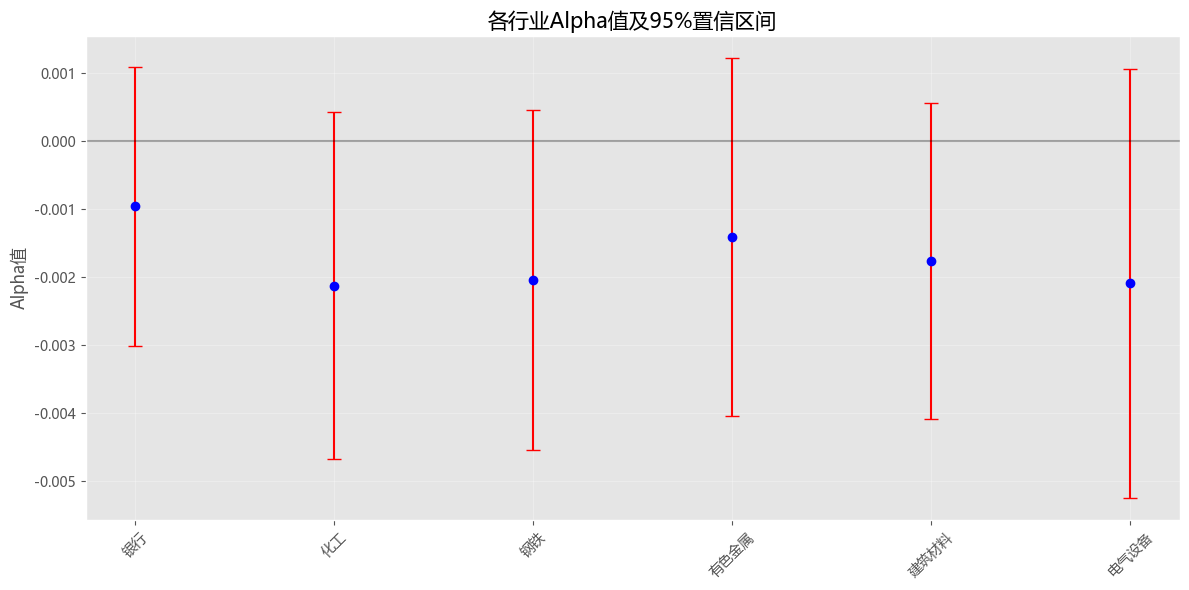

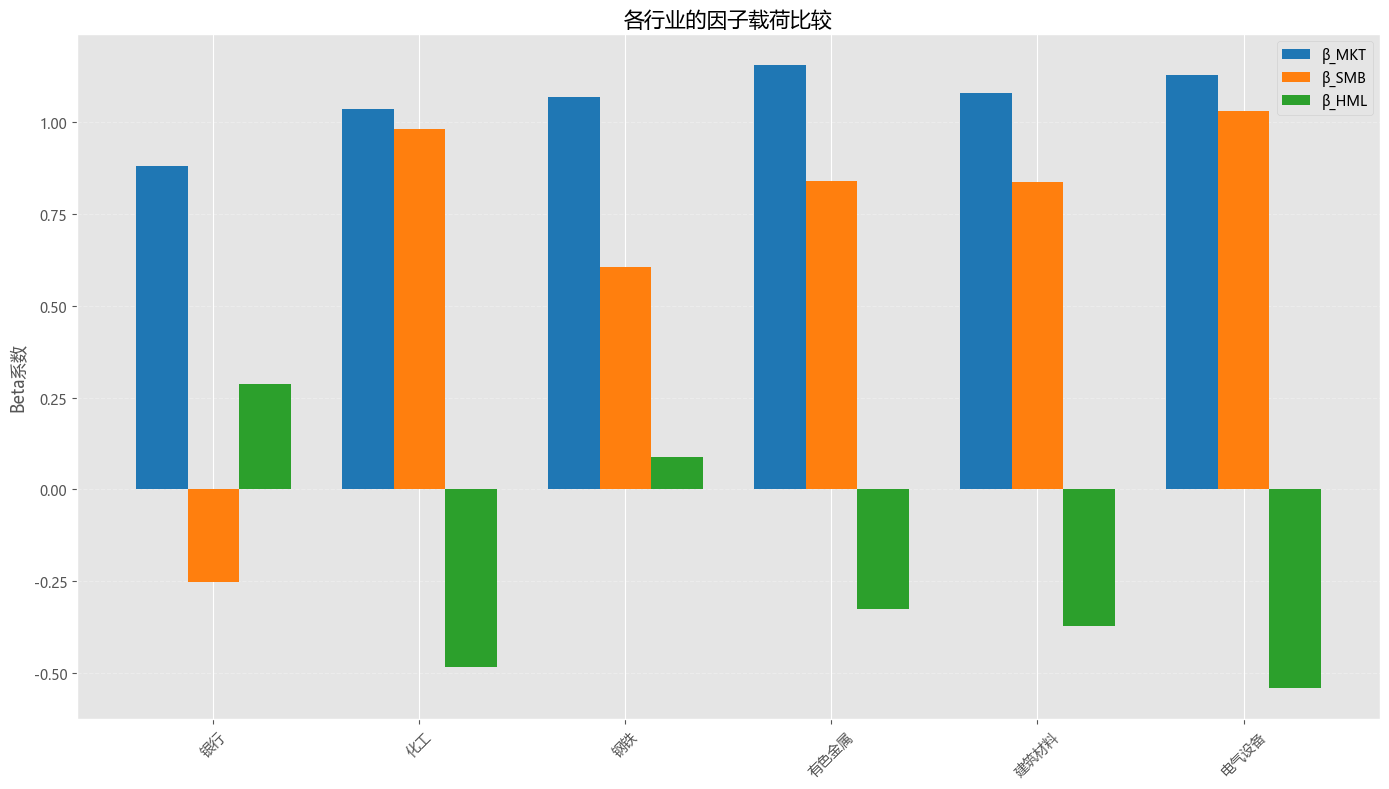

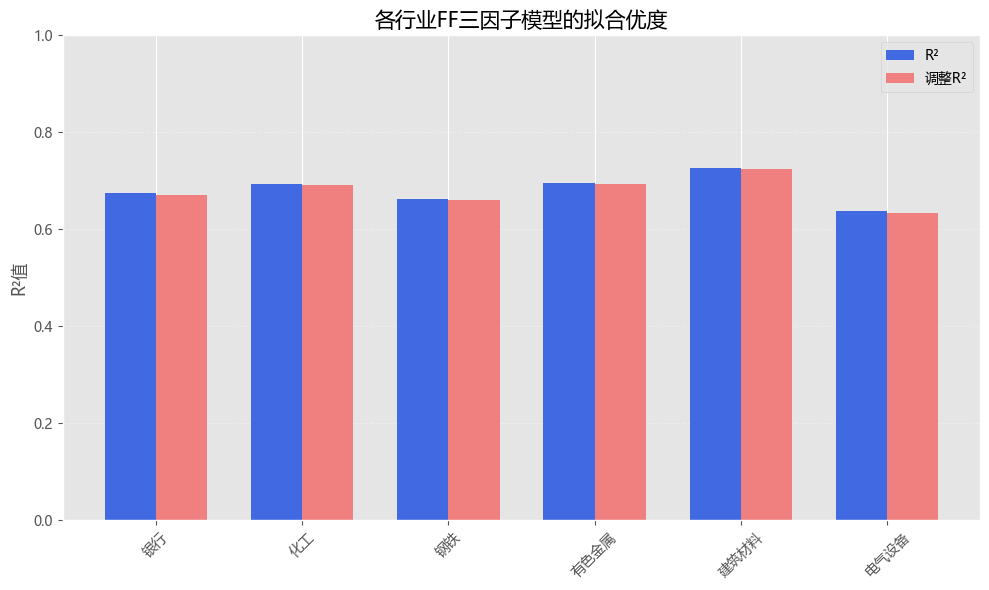

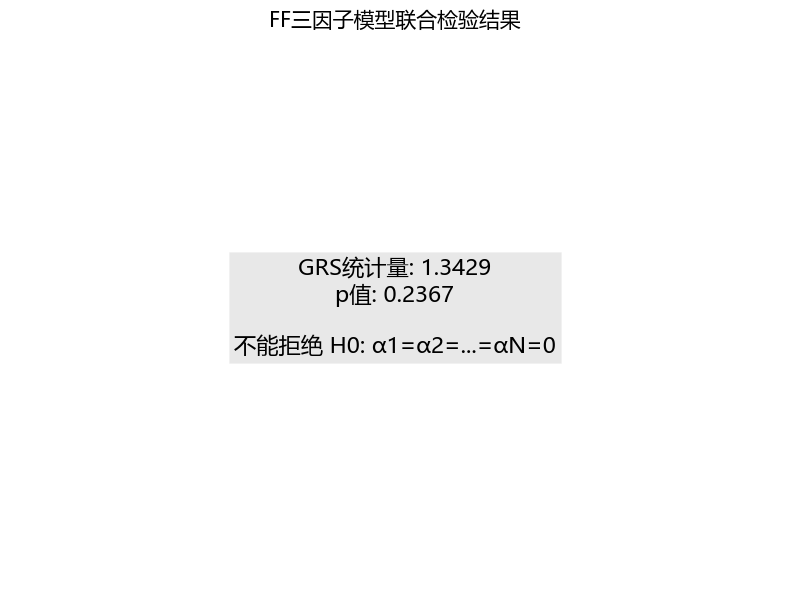

In [12]:
# 进行多资产FF三因子模型检验
if len(industry_returns) >= 2:  # 至少需要两个行业才能进行多资产检验
    joint_test, individual_results = multi_asset_ff_test(industry_returns, factors)
    
    # 可视化多资产检验结果
    if joint_test is not None:
        visualize_multi_asset_test(joint_test, individual_results)

## 横截面检验排序法

In [13]:
import os
import glob

def load_data(file_pattern='RESSET_MRESSTK_*.csv', data_path=None):
    """读取所有匹配的CSV文件并合并数据
    
    参数:
        file_pattern: CSV文件名的模式
        data_path: 数据文件的路径前缀，如果为None则使用当前目录
    """
    # 如果提供了路径，将其与文件模式结合
    if data_path:
        full_pattern = os.path.join(data_path, file_pattern)
    else:
        full_pattern = file_pattern
    
    all_files = glob.glob(full_pattern)
    print(f"找到 {len(all_files)} 个匹配的CSV文件")
    
    data_frames = []
    for file in all_files:
        print(f"读取文件: {file}")
        df = pd.read_csv(file,encoding='gbk')
        data_frames.append(df)
    
    # 合并所有数据帧
    if data_frames:
        combined_df = pd.concat(data_frames, ignore_index=True)
        return combined_df
    else:
        raise FileNotFoundError(f"未找到匹配的文件: {full_pattern}")

In [14]:
def preprocess_data(df):
    """预处理数据：时间格式转换，计算流通市值，处理异常值等"""
    # 检查数据结构
    print("数据列名:", df.columns.tolist())
    print("数据样本:", df.head(2))
    
    # 转换日期格式
    df['日期_Date'] = pd.to_datetime(df['日期_Date'])
    
    # 计算流通市值（流通股 * 收盘价）
    df['流通市值'] = df['流通股_Trdshr'] * df['收盘价_ClPr']
    
    # 计算盈利价格比（市盈率的倒数）
    df['盈利价格比'] = 1 / df['市盈率_PE']
    
    # 处理无效值（市盈率为负、极小或极大的情况）
    df.loc[df['市盈率_PE'] <= 0, '盈利价格比'] = np.nan  # 负的PE没有经济意义
    df.loc[df['市盈率_PE'] > 1000, '盈利价格比'] = np.nan  # 过高的PE可能是异常值
    
    # 统计处理前的极端值情况
    extreme_returns = df[(df['月收益率_Monret'] < -0.5) | (df['月收益率_Monret'] > 0.5)].shape[0]
    print(f"极端月收益率(±50%以外)的记录数: {extreme_returns}, 占比: {extreme_returns/len(df)*100:.2f}%")
    
    # 处理市值极端值
    low_cap = df['流通市值'].quantile(0.01)
    high_cap = df['流通市值'].quantile(0.99)
    df.loc[df['流通市值'] < low_cap, '流通市值'] = np.nan
    df.loc[df['流通市值'] > high_cap, '流通市值'] = np.nan
    
    # 按照年月统计数据量
    df['年月'] = df['日期_Date'].dt.strftime('%Y-%m')
    monthly_counts = df.groupby('年月').size()
    print(f"数据包含 {len(monthly_counts)} 个月份")
    print(f"每月平均数据量: {monthly_counts.mean():.0f} 条记录")
    
    # 按股票和日期排序
    df = df.sort_values(['股票代码_Stkcd', '日期_Date'])
    
    # 打印缺失值统计
    null_counts = df[['流通市值', '盈利价格比', '月收益率_Monret']].isnull().sum()
    print("\n缺失值统计:")
    print(null_counts)
    print(f"总记录数: {len(df)}")
    
    # 返回预处理后的数据
    return df

In [15]:
def sequential_sort(df, date_col='日期_Date', return_col='月收益率_Monret', 
                    first_sort_col='流通市值', second_sort_col='盈利价格比', n_groups=5):
    """
    实现序贯排序法：
    1. 先按第一个变量（流通市值）排序分组，从小到大
    2. 再在每个分组内按第二个变量（盈利价格比）排序分组，从高到低（价值到成长）
    3. 计算每个组合的平均收益率
    """
    results = []
    
    # 打印每个月的数据量情况，帮助调试
    monthly_counts = df.groupby(pd.to_datetime(df[date_col]).dt.strftime('%Y-%m')).size()
    print(f"每月数据量情况(前10个月): \n{monthly_counts.head(10)}")
    
    # 按月份分组处理
    all_months = sorted(df[date_col].unique())
    print(f"数据包含 {len(all_months)} 个月份")
    
    for date in all_months:
        # 获取当月的数据
        month_data = df[df[date_col] == date].copy()
        
        # 确保数据足够大
        if len(month_data) < n_groups * 2:  # 至少需要能形成n_groups×2个组合
            continue
            
        # 删除无效值
        month_data = month_data.dropna(subset=[first_sort_col, second_sort_col, return_col])
        
        # 处理异常值
        month_data = month_data[(month_data[return_col] > -0.5) & (month_data[return_col] < 0.5)]  # 限制月收益率在±50%以内
        month_data = month_data[month_data[second_sort_col] > 0]  # 确保盈利价格比为正
        
        # 检查经过过滤后的数据量
        if len(month_data) < n_groups * 2:
            continue
        
        try:
            # 先按流通市值排序分组（从小到大）
            month_data['size_rank'] = pd.qcut(month_data[first_sort_col], n_groups, labels=False, duplicates='drop')
            
            # 在每个流通市值分组内，按盈利价格比排序再分组（从高到低，即从价值型到成长型）
            for size_rank, size_group in month_data.groupby('size_rank'):
                # 确保每个市值组中有足够的数据
                if len(size_group) < n_groups:
                    continue
                
                # 注意这里的顺序：盈利价格比从高到低排序（价值股到成长股）
                # 使用负值来反转排序顺序，使得ep_rank=0表示最高盈利价格比（最价值型）
                size_group['ep_rank'] = pd.qcut(-size_group[second_sort_col], n_groups, labels=False, duplicates='drop')
                
                # 计算每个分组的平均收益率
                for ep_rank, ep_group in size_group.groupby('ep_rank'):
                    avg_return = ep_group[return_col].mean()
                    results.append({
                        '日期': date,
                        '市值分组': size_rank + 1,  # 从1开始，1表示最小市值
                        '盈利价格比分组': ep_rank + 1,  # 从1开始，1表示最高盈利价格比（最价值型）
                        '平均收益率': avg_return,
                        '股票数量': len(ep_group)
                    })
        except Exception as e:
            print(f"处理 {date} 时出错: {e}")
            continue
    
    results_df = pd.DataFrame(results)
    
    # 打印分组情况统计
    print(f"\n总共生成了 {len(results_df)} 个分组-月份组合")
    if not results_df.empty:
        avg_stocks = results_df['股票数量'].mean()
        print(f"每个组合平均包含 {avg_stocks:.1f} 只股票")
        
        # 检查每个分组的数据量
        group_counts = results_df.groupby(['市值分组', '盈利价格比分组']).size()
        print("\n各分组的月份数量:")
        print(group_counts.unstack())
    
    return results_df

In [16]:
def calculate_final_results(sorted_results):
    """计算最终的各分组时间序列平均收益率"""
    if sorted_results.empty:
        print("警告: 没有可用的排序结果数据")
        # 返回一个空的DataFrame以防止错误
        return pd.DataFrame()
        
    # 按市值和盈利价格比分组计算平均收益率
    final_results = sorted_results.groupby(['市值分组', '盈利价格比分组'])['平均收益率'].mean().reset_index()
    
    # 转换为宽格式表格(类似图片中表3-6的格式)
    pivot_table = final_results.pivot(index='市值分组', columns='盈利价格比分组', values='平均收益率')
    
    # 确保所有的分组都存在，填充缺失值
    all_size_groups = range(1, 6)  # 1到5
    all_ep_groups = range(1, 6)    # 1到5
    
    # 重建完整的索引和列
    pivot_table = pivot_table.reindex(index=all_size_groups, columns=all_ep_groups)
    
    # 添加边缘平均值
    size_means = sorted_results.groupby('市值分组')['平均收益率'].mean()
    ep_means = sorted_results.groupby('盈利价格比分组')['平均收益率'].mean()
    overall_mean = sorted_results['平均收益率'].mean()
    
    # 创建完整表格
    pivot_table['市值组平均'] = size_means
    
    # 计算列平均值并添加到表格底部
    ep_means_row = pd.Series(index=pivot_table.columns)
    for col in all_ep_groups:
        if col in pivot_table.columns:
            ep_means_row[col] = pivot_table[col].mean()
    ep_means_row['市值组平均'] = overall_mean
    
    pivot_table.loc['盈利价格比组平均'] = ep_means_row
    
    # 打印数据点数量
    point_counts = sorted_results.groupby(['市值分组', '盈利价格比分组']).size().unstack()
    print("\n各分组的数据点数量:")
    print(point_counts)
    
    # 打印每个分组的样本股票数量
    stock_counts = sorted_results.groupby(['市值分组', '盈利价格比分组'])['股票数量'].mean().unstack()
    print("\n各分组的平均股票数量:")
    print(stock_counts)
    
    return pivot_table

In [17]:
def plot_heatmap(pivot_table):
    """绘制排序结果的热力图"""
    plt.figure(figsize=(12, 10))
    
    # 去除最后一行和最后一列(边缘均值)来绘制核心数据
    core_data = pivot_table.iloc[:-1, :-1]
    
    sns.heatmap(core_data, annot=True, cmap='RdYlBu_r', fmt='.4f', 
                xticklabels=core_data.columns, yticklabels=core_data.index)
    plt.title('中国股市按市值和盈利价格比序贯排序的月平均收益率热力图 (2004-2023)')
    plt.xlabel('盈利价格比分组 (从低到高)')
    plt.ylabel('市值分组 (从小到大)')
    plt.tight_layout()
    plt.show()

In [18]:
def analyze_results(pivot_table):
    """分析排序结果并提供见解"""
    if pivot_table.empty:
        print("警告: 没有可用的结果数据进行分析")
        # 返回空结果
        return {
            'size_effect': np.nan,
            'value_effect': np.nan,
            'small_value_return': np.nan,
            'large_growth_return': np.nan,
            'size_pattern': [],
            'value_pattern': []
        }
    
    # 提取不含边缘均值的核心数据
    core_data = pivot_table.iloc[:-1, :-1]
    
    # 计算规模效应(行方向的趋势)
    size_effect = core_data.mean(axis=1)
    # 现在size_rank=1是最小市值，size_rank=5是最大市值
    size_diff = size_effect.iloc[-1] - size_effect.iloc[0]  # 大市值收益 - 小市值收益
    
    # 计算价值效应(列方向的趋势)
    value_effect = core_data.mean(axis=0)
    # 现在ep_rank=1是最高EP(最价值型)，ep_rank=5是最低EP(最成长型)
    value_diff = value_effect.iloc[0] - value_effect.iloc[-1]  # 高EP收益 - 低EP收益
    
    # 检查最小市值和最高盈利价格比组合(小市值价值股)
    small_value_return = core_data.iloc[0, 0] if 0 in core_data.index and 0 in core_data.columns else np.nan
    
    # 检查最大市值和最低盈利价格比组合(大市值成长股)
    large_growth_return = core_data.iloc[-1, -1] if len(core_data.index) > 0 and len(core_data.columns) > 0 else np.nan
    
    # 输出详细的各分组平均收益率
    print("\n市值分组平均收益率(从小到大):")
    for i, val in enumerate(size_effect.items()):
        print(f"市值分组 {val[0]}: {val[1]:.4f}")
    
    print("\n盈利价格比分组平均收益率(从高到低/价值到成长):")
    for i, val in enumerate(value_effect.items()):
        print(f"盈利价格比分组 {val[0]}: {val[1]:.4f}")
    
    # 返回分析结果
    return {
        'size_effect': size_diff,
        'value_effect': value_diff,
        'small_value_return': small_value_return,
        'large_growth_return': large_growth_return,
        'size_pattern': [(i, v) for i, v in size_effect.items()],
        'value_pattern': [(i, v) for i, v in value_effect.items()]
    }

正在读取数据文件...
找到 9 个匹配的CSV文件
读取文件: ./assets/data/course\RESSET_MRESSTK_1.csv
读取文件: ./assets/data/course\RESSET_MRESSTK_2.csv
读取文件: ./assets/data/course\RESSET_MRESSTK_3.csv
读取文件: ./assets/data/course\RESSET_MRESSTK_4.csv
读取文件: ./assets/data/course\RESSET_MRESSTK_5.csv
读取文件: ./assets/data/course\RESSET_MRESSTK_6.csv
读取文件: ./assets/data/course\RESSET_MRESSTK_7.csv
读取文件: ./assets/data/course\RESSET_MRESSTK_8.csv
读取文件: ./assets/data/course\RESSET_MRESSTK_9.csv
数据读取完成，共有 437761 条记录
正在预处理数据...
数据列名: ['股票代码_Stkcd', '日期_Date', '收盘价_ClPr', '总股数_Fullshr', '流通股_Trdshr', '月收益率_Monret', '月无风险收益率_Monrfret', '市盈率_PE', 'Unnamed: 8']
数据样本:    股票代码_Stkcd     日期_Date  收盘价_ClPr   总股数_Fullshr    流通股_Trdshr  月收益率_Monret  \
0           1  2000-01-28     18.53  1.551847e+09  1.071634e+09       0.0619   
1           1  2000-02-29     18.32  1.551847e+09  1.071634e+09      -0.0113   

   月无风险收益率_Monrfret  市盈率_PE  Unnamed: 8  
0           0.00165   51.90         NaN  
1           0.00165   51.32         NaN  
极端月收

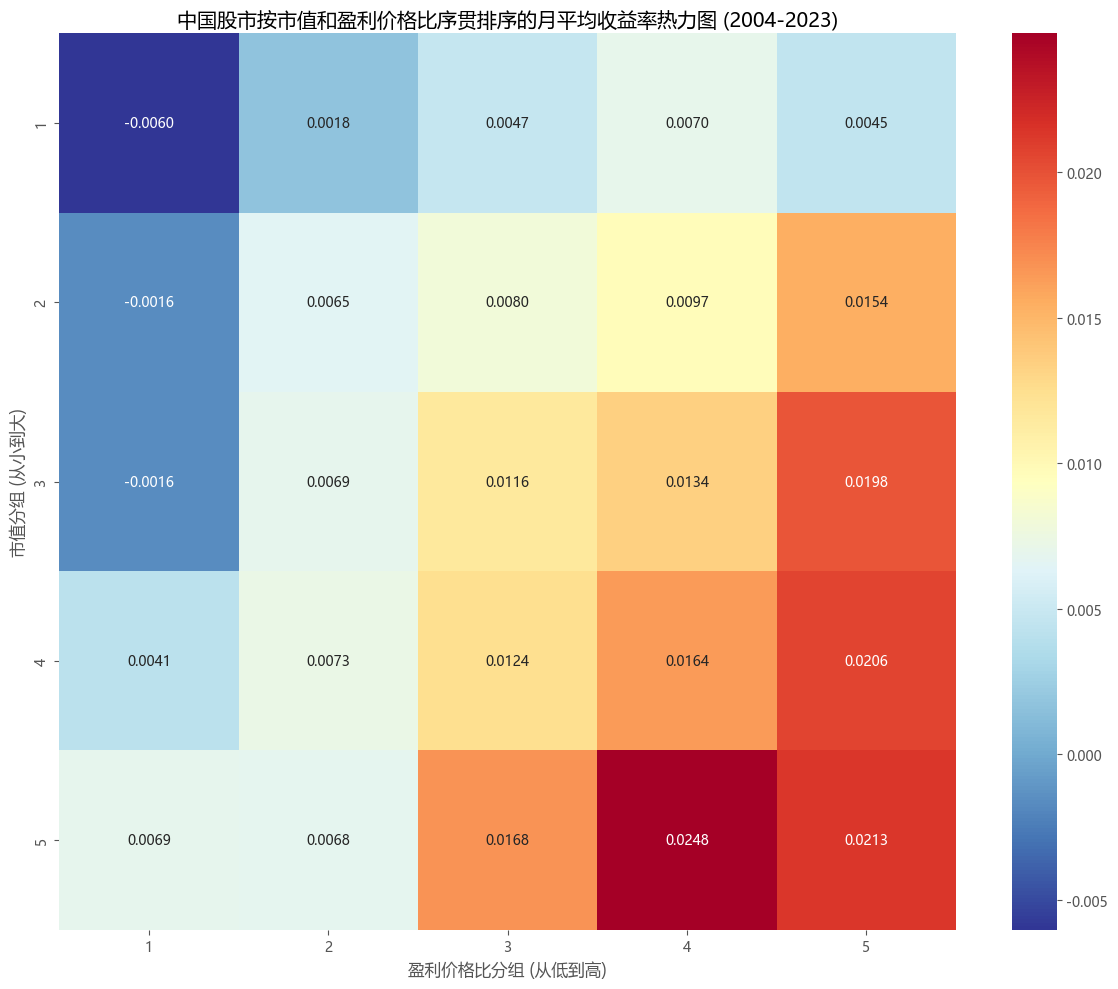


结果分析:

市值分组平均收益率(从小到大):
市值分组 1: 0.0024
市值分组 2: 0.0076
市值分组 3: 0.0100
市值分组 4: 0.0122
市值分组 5: 0.0153

盈利价格比分组平均收益率(从高到低/价值到成长):
盈利价格比分组 1: 0.0004
盈利价格比分组 2: 0.0059
盈利价格比分组 3: 0.0107
盈利价格比分组 4: 0.0143
盈利价格比分组 5: 0.0163
市值效应大小: 0.0129
价值效应大小: -0.0160
小市值-高盈利价格比组合的月平均收益率: nan
大市值-低盈利价格比组合的月平均收益率: 0.0213

市值分组平均收益率趋势 (从小到大):
市值分组 1 - (1, 0.002389555500493198)
市值分组 2 - (2, 0.007610399566819974)
市值分组 3 - (3, 0.0100183260191506)
市值分组 4 - (4, 0.012163562133170169)
市值分组 5 - (5, 0.015335599500409794)

盈利价格比分组平均收益率趋势 (从低到高):
盈利价格比分组 1 - (1, 0.0003539494470613979)
盈利价格比分组 2 - (2, 0.005867026052530873)
盈利价格比分组 3 - (3, 0.010704778921972854)
盈利价格比分组 4 - (4, 0.014261683193569413)
盈利价格比分组 5 - (5, 0.016330005104909194)

结论讨论:
- 存在反向市值效应: 大市值股票表现优于小市值股票
- 存在反向价值效应: 低盈利价格比(高市盈率)股票表现优于高盈利价格比(低市盈率)股票
- 大市值-低盈利价格比(成长型)组合表现优于小市值-高盈利价格比(价值型)组合


In [21]:
# 1. 读取所有数据文件
print("正在读取数据文件...")
df = load_data(data_path='./assets/data/course')
print(f"数据读取完成，共有 {len(df)} 条记录")

# 2. 数据预处理
print("正在预处理数据...")
processed_df = preprocess_data(df)
print(f"数据预处理完成，预处理后有 {len(processed_df)} 条有效记录")

# 输出数据样本和基本统计信息
print("\n数据样本:")
print(processed_df.head())
print("\n基本统计信息:")
print(processed_df[['收盘价_ClPr', '流通市值', '月收益率_Monret', '市盈率_PE', '盈利价格比']].describe())

# 3. 执行序贯排序
print("\n正在执行序贯排序...")
sorted_results = sequential_sort(processed_df)
print(f"排序完成，结果包含 {len(sorted_results)} 个分组-月份组合")

# 4. 计算最终结果
print("\n正在计算最终结果...")
final_table = calculate_final_results(sorted_results)
print("\n序贯排序结果表 (月平均收益率):")
print(final_table)

# 5. 绘制热力图
print("\n正在绘制热力图...")
plot_heatmap(final_table)

# 6. 分析结果
print("\n结果分析:")
analysis = analyze_results(final_table)

print(f"市值效应大小: {analysis['size_effect']:.4f}")
print(f"价值效应大小: {analysis['value_effect']:.4f}")
print(f"小市值-高盈利价格比组合的月平均收益率: {analysis['small_value_return']:.4f}")
print(f"大市值-低盈利价格比组合的月平均收益率: {analysis['large_growth_return']:.4f}")

print("\n市值分组平均收益率趋势 (从小到大):")
for i, val in enumerate(analysis['size_pattern'], 1):
    print(f"市值分组 {i} - {val}")

print("\n盈利价格比分组平均收益率趋势 (从低到高):")
for i, val in enumerate(analysis['value_pattern'], 1):
   print(f"盈利价格比分组 {i} - {val}")

# 7. 讨论结论
print("\n结论讨论:")
if analysis['size_effect'] < 0:
    print("- 发现了显著的市值效应: 小市值股票倾向于获得高于大市值股票的收益")
elif analysis['size_effect'] > 0:
    print("- 存在反向市值效应: 大市值股票表现优于小市值股票")
else:
    print("- 没有发现明显的市值效应")
    
if analysis['value_effect'] > 0:
    print("- 发现了显著的价值效应: 高盈利价格比(低市盈率)股票表现优于低盈利价格比(高市盈率)股票")
elif analysis['value_effect'] < 0:
    print("- 存在反向价值效应: 低盈利价格比(高市盈率)股票表现优于高盈利价格比(低市盈率)股票")
else:
    print("- 没有发现明显的价值效应")

if analysis['small_value_return'] > analysis['large_growth_return']:
    print("- 小市值-高盈利价格比(价值型)组合显著优于大市值-低盈利价格比(成长型)组合")
else:
    print("- 大市值-低盈利价格比(成长型)组合表现优于小市值-高盈利价格比(价值型)组合")

## Fama-MacBeth回归

In [22]:
# load—data，process-data可以直接复用横截面的

def calculate_beta(df, window=36):
    """
    使用数据计算每只股票的Beta值
    
    参数:
        df: 包含股票收益率数据的DataFrame
        window: 计算Beta使用的滚动窗口长度(月数)
    
    返回:
        df_with_beta: 添加Beta列的DataFrame
    """
    print("开始使用本地数据计算Beta值...")
    
    # 确保日期格式正确
    df['日期_Date'] = pd.to_datetime(df['日期_Date'])
    
    # 计算每个月的市场平均收益率(等权)
    market_returns = df.groupby('日期_Date')['月收益率_Monret'].mean().reset_index()
    market_returns.columns = ['日期_Date', '市场收益率']
    
    print(f"已计算{len(market_returns)}个月的市场平均收益率")
    
    # 合并市场收益率到主数据框
    df_merged = pd.merge(df, market_returns, on='日期_Date', how='left')
    
    # 计算无风险收益率调整后的超额收益率
    df_merged['超额收益率'] = df_merged['月收益率_Monret'] - df_merged['月无风险收益率_Monrfret']
    df_merged['市场超额收益率'] = df_merged['市场收益率'] - df_merged['月无风险收益率_Monrfret']
    
    # 为每只股票计算Beta值
    print(f"开始为股票计算Beta值，使用{window}个月的滚动窗口...")
    
    # 获取所有股票代码
    stock_codes = df_merged['股票代码_Stkcd'].unique()
    print(f"共有{len(stock_codes)}只股票需要计算Beta")
    
    # 用于存储结果的列表
    beta_results = []
    
    # 对每只股票进行处理
    for i, stock in enumerate(stock_codes):
        if i % 100 == 0:
            print(f"已处理 {i}/{len(stock_codes)} 只股票")
        
        # 获取该股票的数据
        stock_data = df_merged[df_merged['股票代码_Stkcd'] == stock].copy()
        
        # 按日期排序
        stock_data = stock_data.sort_values('日期_Date')
        
        # 如果数据点少于窗口大小，则计算全样本Beta
        if len(stock_data) < window:
            try:
                # 执行回归计算Beta
                X = sm.add_constant(stock_data['市场超额收益率'])
                y = stock_data['超额收益率']
                model = sm.OLS(y, X).fit()
                beta = model.params['市场超额收益率']  # 这是CAPM Beta
                
                # 对于合理范围外的Beta，进行修正
                if beta < -3 or beta > 3:
                    beta = 1.0  # 使用1.0作为默认值
                
                # 为每个月份添加相同的Beta
                for _, row in stock_data.iterrows():
                    beta_results.append({
                        '股票代码_Stkcd': stock,
                        '日期_Date': row['日期_Date'],
                        'Beta': beta
                    })
            except:
                # 如果回归失败，则使用1.0作为默认Beta
                for _, row in stock_data.iterrows():
                    beta_results.append({
                        '股票代码_Stkcd': stock,
                        '日期_Date': row['日期_Date'],
                        'Beta': 1.0
                    })
        else:
            # 对于数据点充足的股票，计算滚动Beta
            for j in range(window, len(stock_data) + 1):
                window_data = stock_data.iloc[j-window:j]
                current_date = window_data.iloc[-1]['日期_Date']
                
                try:
                    # 执行回归计算Beta
                    X = sm.add_constant(window_data['市场超额收益率'])
                    y = window_data['超额收益率']
                    model = sm.OLS(y, X).fit()
                    beta = model.params['市场超额收益率']  # 这是CAPM Beta
                    
                    # 对于合理范围外的Beta，进行修正
                    if beta < -3 or beta > 3:
                        beta = 1.0  # 使用1.0作为默认值
                except:
                    # 如果回归失败，则使用1.0作为默认Beta
                    beta = 1.0
                
                beta_results.append({
                    '股票代码_Stkcd': stock,
                    '日期_Date': current_date,
                    'Beta': beta
                })
    
    # 将结果转换为DataFrame
    beta_df = pd.DataFrame(beta_results)
    
    # 将Beta结果合并到原始数据中
    df_with_beta = pd.merge(df, beta_df, on=['股票代码_Stkcd', '日期_Date'], how='left')
    
    # 检查是否有缺失的Beta值
    missing_beta = df_with_beta['Beta'].isna().sum()
    if missing_beta > 0:
        print(f"警告: 有{missing_beta}条记录缺少Beta值 ({missing_beta/len(df_with_beta):.2%})，使用1.0填充")
        df_with_beta.loc[df_with_beta['Beta'].isna(), 'Beta'] = 1.0
    
    print("Beta计算完成!")
    
    return df_with_beta

In [23]:
def fama_macbeth_regression(df, start_date='2004-01-01', end_date='2023-12-31'):
    """
    执行Fama-MacBeth两阶段回归
    
    参数:
        df: 包含所需数据的DataFrame
        start_date: 分析开始日期
        end_date: 分析结束日期
    
    返回:
        fm_results: 包含回归结果的DataFrame
    """
    print("开始执行Fama-MacBeth回归...")
    
    # 筛选时间范围内的数据
    df = df[(df['日期_Date'] >= start_date) & (df['日期_Date'] <= end_date)].copy()
    
    # 确保列名存在
    required_cols = ['日期_Date', '股票代码_Stkcd', '月收益率_Monret', '对数流通市值', '盈利价格比', 'Beta']
    for col in required_cols:
        if col not in df.columns and col != 'Beta':
            if col == '对数流通市值' and '流通市值' in df.columns:
                df['对数流通市值'] = np.log(df['流通市值'])
            elif col == '盈利价格比' and '市盈率_PE' in df.columns:
                df['盈利价格比'] = 1 / df['市盈率_PE']
                # 处理无效值
                df.loc[df['市盈率_PE'] <= 0, '盈利价格比'] = np.nan
                df.loc[df['市盈率_PE'] > 1000, '盈利价格比'] = np.nan
            else:
                raise ValueError(f"缺少所需列: {col}")
    
    # 如果Beta列不存在，尝试计算或者从其他列中获取
    if 'Beta' not in df.columns:
        print("警告: 数据中没有Beta列，假设Beta值等于1")
        df['Beta'] = 1.0
    
    # 对所有变量进行缩尾处理（即处理极端值）
    for col in ['对数流通市值', '盈利价格比', 'Beta']:
        if col in df.columns:
            # 对每个月的数据单独进行缩尾处理
            df[col + '_winsorized'] = df.groupby('年月')[col].transform(
                lambda x: x.clip(lower=x.quantile(0.01), upper=x.quantile(0.99))
            )
        else:
            print(f"警告：缺少列 {col}，跳过缩尾处理")
    
    # 打印处理后的数据样本
    print("\n处理后的数据样本:")
    print(df.head())
    
    # 获取所有唯一的月份
    all_months = df['日期_Date'].dt.to_period('M').unique()
    all_months = sorted(all_months)
    print(f"分析期间共有 {len(all_months)} 个月份")
    
    # 用于存储每个月的横截面回归结果
    monthly_results = []
    
    # 对每个月执行横截面回归
    for month in all_months:
        month_str = str(month)
        month_start = month_str + '-01'
        month_end = pd.Period(month).asfreq('D', 'end').strftime('%Y-%m-%d')
        
        # 获取当月数据
        month_data = df[(df['日期_Date'] >= month_start) & (df['日期_Date'] <= month_end)].copy()
        
        # 确保数据充足
        if len(month_data) < 30:  # 至少需要30个观测值
            print(f"警告: {month_str} 的数据不足，跳过")
            continue
        
        # 删除缺失值
        month_data = month_data.dropna(subset=['月收益率_Monret', '对数流通市值_winsorized', 
                                              '盈利价格比_winsorized', 'Beta_winsorized'])
        
        if len(month_data) < 30:
            print(f"警告: 删除缺失值后 {month_str} 的数据不足，跳过")
            continue
        
        # 准备回归数据
        X = sm.add_constant(month_data[['Beta_winsorized', '对数流通市值_winsorized', '盈利价格比_winsorized']])
        y = month_data['月收益率_Monret']
        
        try:
            # 执行OLS回归
            model = sm.OLS(y, X)
            results = model.fit()
            
            # 收集结果
            monthly_results.append({
                '月份': month_str,
                '常数项': results.params['const'],
                'Beta': results.params['Beta_winsorized'],
                '对数流通市值': results.params['对数流通市值_winsorized'],
                '盈利价格比': results.params['盈利价格比_winsorized'],
                '常数项_t值': results.tvalues['const'],
                'Beta_t值': results.tvalues['Beta_winsorized'],
                '对数流通市值_t值': results.tvalues['对数流通市值_winsorized'],
                '盈利价格比_t值': results.tvalues['盈利价格比_winsorized'],
                'R平方': results.rsquared,
                '样本数': len(month_data)
            })
            
            if len(monthly_results) % 12 == 0:
                print(f"已完成 {len(monthly_results)} 个月的回归")
                
        except Exception as e:
            print(f"对 {month_str} 执行回归时出错: {e}")
            continue
    
    # 将结果转换为DataFrame
    fm_results = pd.DataFrame(monthly_results)
    
    # 计算Fama-MacBeth第二阶段结果（时间序列平均值和t统计量）
    coef_means = fm_results[['常数项', 'Beta', '对数流通市值', '盈利价格比']].mean()
    coef_stds = fm_results[['常数项', 'Beta', '对数流通市值', '盈利价格比']].std()
    
    # 计算时间序列t统计量（Newey-West调整前的简单t统计量）
    n_periods = len(fm_results)
    coef_t_stats = coef_means / (coef_stds / np.sqrt(n_periods))
    
    print("\nFama-MacBeth回归结果（时间序列平均值）:")
    for coef, mean_val, t_stat in zip(['常数项', 'Beta', '对数流通市值', '盈利价格比'], 
                                   coef_means, coef_t_stats):
        print(f"{coef}: {mean_val:.6f} (t = {t_stat:.2f})")
    
    # 计算每个月的R平方均值
    mean_rsquared = fm_results['R平方'].mean()
    print(f"平均R平方: {mean_rsquared:.4f}")
    
    return fm_results

In [24]:
def plot_coefficient_time_series(fm_results):
    """绘制系数的时间序列图"""
    # 转换月份为时间格式
    fm_results['月份'] = pd.to_datetime(fm_results['月份'])
    
    # 设置图像大小
    plt.figure(figsize=(15, 10))
    
    # 绘制Beta系数的时间序列图
    plt.subplot(2, 2, 1)
    plt.plot(fm_results['月份'], fm_results['Beta'], 'b-')
    plt.title('Beta系数的时间序列')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('月份')
    plt.ylabel('系数值')
    
    # 绘制对数流通市值系数的时间序列图
    plt.subplot(2, 2, 2)
    plt.plot(fm_results['月份'], fm_results['对数流通市值'], 'g-')
    plt.title('对数流通市值系数的时间序列')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('月份')
    plt.ylabel('系数值')
    
    # 绘制盈利价格比系数的时间序列图
    plt.subplot(2, 2, 3)
    plt.plot(fm_results['月份'], fm_results['盈利价格比'], 'r-')
    plt.title('盈利价格比系数的时间序列')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('月份')
    plt.ylabel('系数值')
    
    # 绘制R平方的时间序列图
    plt.subplot(2, 2, 4)
    plt.plot(fm_results['月份'], fm_results['R平方'], 'k-')
    plt.title('R平方的时间序列')
    plt.xlabel('月份')
    plt.ylabel('R平方')
    
    plt.tight_layout()
    plt.show()

In [25]:
def visualize_results(full_results, subperiod_results, subperiods):
    """生成更多可视化图表展示Fama-MacBeth回归结果"""
    
    # 1. 系数均值与标准差对比图
    plt.figure(figsize=(12, 8))
    
    # 准备数据
    coef_names = ['常数项', 'Beta', '对数流通市值', '盈利价格比']
    coef_means = full_results[coef_names].mean()
    coef_stds = full_results[coef_names].std()
    
    # 绘制均值柱状图
    x = np.arange(len(coef_names))
    bar_width = 0.35
    
    plt.bar(x, coef_means, bar_width, label='系数均值', color='skyblue')
    
    # 添加误差线（标准差）
    plt.errorbar(x, coef_means, yerr=coef_stds, fmt='o', color='navy', capsize=5)
    
    # 添加零线
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    # 添加t统计量标签
    for i, (mean, std) in enumerate(zip(coef_means, coef_stds)):
        t_stat = mean / (std / np.sqrt(len(full_results)))
        plt.text(i, mean + (0.01 if mean >= 0 else -0.01), 
                 f't={t_stat:.2f}', ha='center', fontsize=10)
    
    plt.xticks(x, coef_names)
    plt.ylabel('系数值')
    plt.title('Fama-MacBeth回归系数均值与标准差 (2004-2023)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 2. 子期间系数比较
    plt.figure(figsize=(12, 8))
    
    # 准备数据
    period_labels = [f'子期间{i+1}\n({period.split(":")[0]} 至 {period.split(":")[1]})' 
                     for i, period in enumerate(subperiods)]
    period_labels.insert(0, f'全期间\n({subperiods[0].split(":")[0]} 至 {subperiods[-1].split(":")[1]})')
    
    # 合并全期间和子期间的结果
    all_results = [full_results] + subperiod_results
    all_means = [df[coef_names].mean() for df in all_results]
    all_means_df = pd.DataFrame(all_means)
    
    # 绘制子图，每个系数一个
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Fama-MacBeth回归系数在不同时期的对比', fontsize=16)
    
    for i, coef in enumerate(coef_names):
        ax = axes[i//2, i%2]
        means = [df[coef].mean() for df in all_results]
        stds = [df[coef].std() / np.sqrt(len(df)) for df in all_results]  # 标准误
        
        x = np.arange(len(period_labels))
        ax.bar(x, means, width=0.6, alpha=0.7, color=['blue', 'green', 'orange'])
        ax.errorbar(x, means, yerr=stds, fmt='o', color='black', capsize=5)
        
        # 添加零线
        ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        
        # 添加t统计量标签
        for j, (mean, std) in enumerate(zip(means, stds)):
            t_stat = mean / std if std != 0 else float('nan')
            ax.text(j, mean + (0.01 if mean >= 0 else -0.01), 
                    f't={t_stat:.2f}', ha='center', fontsize=9)
        
        ax.set_xticks(x)
        ax.set_xticklabels(period_labels, rotation=45, ha='right')
        ax.set_title(f'{coef}系数')
        ax.set_ylabel('系数值')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 调整整体布局
    plt.show()
    
    # 3. 绘制R平方对比
    plt.figure(figsize=(10, 6))
    r_squared_means = [df['R平方'].mean() for df in all_results]
    
    plt.bar(period_labels, r_squared_means, alpha=0.7, color=['blue', 'green', 'orange'])
    
    # 添加数值标签
    for i, r_squared in enumerate(r_squared_means):
        plt.text(i, r_squared + 0.01, f'{r_squared:.4f}', ha='center')
    
    plt.ylabel('平均R平方')
    plt.title('不同时期的Fama-MacBeth回归平均R平方对比')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # 4. 系数显著性比例对比
    plt.figure(figsize=(12, 7))
    
    # 计算各期间系数显著的比例
    sig_ratios = []
    for results in all_results:
        period_sig = {
            'Beta': (np.abs(results['Beta_t值']) > 1.96).mean(),
            '对数流通市值': (np.abs(results['对数流通市值_t值']) > 1.96).mean(),
            '盈利价格比': (np.abs(results['盈利价格比_t值']) > 1.96).mean()
        }
        sig_ratios.append(period_sig)
    
    sig_df = pd.DataFrame(sig_ratios, index=period_labels)
    
    # 绘制堆叠柱状图
    sig_df.plot(kind='bar', stacked=False, figsize=(12, 7), alpha=0.7)
    plt.title('不同时期各系数显著月份的比例 (|t| > 1.96)')
    plt.ylabel('显著月份比例')
    plt.ylim(0, 1)
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
    
    # 添加百分比标签
    for i, row in enumerate(sig_df.iterrows()):
        for j, val in enumerate(row[1]):
            plt.text(i+j*0.25-0.3, val + 0.02, f'{val:.0%}', ha='center', fontsize=9)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [26]:
def summary_statistics(fm_results):
    """计算并打印描述性统计信息"""
    print("\n系数描述性统计:")
    stats_df = fm_results[['常数项', 'Beta', '对数流通市值', '盈利价格比', 'R平方']].describe()
    print(stats_df)
    
    # 计算年度平均值
    fm_results['年份'] = pd.to_datetime(fm_results['月份']).dt.year
    yearly_means = fm_results.groupby('年份')[['常数项', 'Beta', '对数流通市值', '盈利价格比', 'R平方']].mean()
    
    print("\n年度平均系数:")
    print(yearly_means)
    
    # 分析显著性
    sig_counts = {
        'Beta': (np.abs(fm_results['Beta_t值']) > 1.96).sum() / len(fm_results),
        '对数流通市值': (np.abs(fm_results['对数流通市值_t值']) > 1.96).sum() / len(fm_results),
        '盈利价格比': (np.abs(fm_results['盈利价格比_t值']) > 1.96).sum() / len(fm_results)
    }
    
    print("\n各系数显著的月份比例 (|t| > 1.96):")
    for coef, sig_ratio in sig_counts.items():
        print(f"{coef}: {sig_ratio:.2%}")


In [27]:
def run_fama_macbeth_with_subperiods(df, full_period='2004-01-01:2023-12-31', 
                                    subperiods=['2004-01-01:2013-12-31', '2014-01-01:2023-12-31']):
    """针对不同时间段运行Fama-MacBeth回归"""
    # 整体期间的回归
    full_start, full_end = full_period.split(':')
    print(f"\n执行完整期间 ({full_start} 至 {full_end}) 的Fama-MacBeth回归...")
    full_results = fama_macbeth_regression(df, start_date=full_start, end_date=full_end)
    
    # 执行各子期间的回归
    subperiod_results = []
    for i, period in enumerate(subperiods):
        start_date, end_date = period.split(':')
        print(f"\n执行子期间{i+1} ({start_date} 至 {end_date}) 的Fama-MacBeth回归...")
        sub_results = fama_macbeth_regression(df, start_date=start_date, end_date=end_date)
        subperiod_results.append(sub_results)
    
    # 返回结果
    return full_results, subperiod_results

In [ ]:
def analyze_fm_results(full_results, subperiod_results, subperiods):
    """分析Fama-MacBeth回归结果"""
    # 整体期间的结果分析
    print("\n\n=============================================")
    print("Fama-MacBeth回归结果分析")
    print("=============================================")
    
    # 计算并打印全期间的结果
    coef_means = full_results[['常数项', 'Beta', '对数流通市值', '盈利价格比']].mean()
    coef_stds = full_results[['常数项', 'Beta', '对数流通市值', '盈利价格比']].std()
    n_periods = len(full_results)
    coef_t_stats = coef_means / (coef_stds / np.sqrt(n_periods))
    
    print("\n完整期间回归结果:")
    for coef, mean_val, t_stat in zip(['常数项', 'Beta', '对数流通市值', '盈利价格比'], 
                                   coef_means, coef_t_stats):
        sig = ''
        if abs(t_stat) > 2.58:
            sig = '***'
        elif abs(t_stat) > 1.96:
            sig = '**'
        elif abs(t_stat) > 1.645:
            sig = '*'
        print(f"{coef}: {mean_val:.6f} (t = {t_stat:.2f}) {sig}")
    
    # 解释星号的含义
    print("\n显著性标记: * p<0.1, ** p<0.05, *** p<0.01")
    
    # 分析子期间的结果
    print("\n子期间回归结果:")
    for i, (sub_results, period) in enumerate(zip(subperiod_results, subperiods)):
        start_date, end_date = period.split(':')
        coef_means = sub_results[['常数项', 'Beta', '对数流通市值', '盈利价格比']].mean()
        coef_stds = sub_results[['常数项', 'Beta', '对数流通市值', '盈利价格比']].std()
        n_periods = len(sub_results)
        coef_t_stats = coef_means / (coef_stds / np.sqrt(n_periods))
        
        print(f"\n子期间{i+1} ({start_date} 至 {end_date}):")
        for coef, mean_val, t_stat in zip(['常数项', 'Beta', '对数流通市值', '盈利价格比'], 
                                       coef_means, coef_t_stats):
            sig = ''
            if abs(t_stat) > 2.58:
                sig = '***'
            elif abs(t_stat) > 1.96:
                sig = '**'
            elif abs(t_stat) > 1.645:
                sig = '*'
            print(f"{coef}: {mean_val:.6f} (t = {t_stat:.2f}) {sig}")
    
    # 整体结论
    print("\n\n========== Fama-MacBeth回归分析结论 ==========")
    
    # Beta系数分析
    beta_full_mean = full_results['Beta'].mean()
    beta_full_t = beta_full_mean / (full_results['Beta'].std() / np.sqrt(len(full_results)))
    if abs(beta_full_t) > 1.96:
        beta_conclusion = f"Beta系数在整体期间显著 ({beta_full_mean:.4f}, t={beta_full_t:.2f})，表明CAPM风险因子在中国股市有解释力。"
    else:
        beta_conclusion = f"Beta系数在整体期间不显著 ({beta_full_mean:.4f}, t={beta_full_t:.2f})，表明CAPM风险因子在中国股市解释力有限。"
    print(beta_conclusion)
    
    # 市值效应分析
    size_full_mean = full_results['对数流通市值'].mean()
    size_full_t = size_full_mean / (full_results['对数流通市值'].std() / np.sqrt(len(full_results)))
    if abs(size_full_t) > 1.96:
        if size_full_mean < 0:
            size_conclusion = f"对数流通市值系数显著为负 ({size_full_mean:.4f}, t={size_full_t:.2f})，证实了小公司效应：小市值股票倾向于获得更高收益。"
        else:
            size_conclusion = f"对数流通市值系数显著为正 ({size_full_mean:.4f}, t={size_full_t:.2f})，表明中国股市存在反向规模效应：大市值股票倾向于获得更高收益。"
    else:
        size_conclusion = f"对数流通市值系数不显著 ({size_full_mean:.4f}, t={size_full_t:.2f})，表明市值因素对股票收益解释力有限。"
    print(size_conclusion)
    
    # 价值效应分析
    ep_full_mean = full_results['盈利价格比'].mean()
    ep_full_t = ep_full_mean / (full_results['盈利价格比'].std() / np.sqrt(len(full_results)))
    if abs(ep_full_t) > 1.96:
        if ep_full_mean > 0:
            ep_conclusion = f"盈利价格比系数显著为正 ({ep_full_mean:.4f}, t={ep_full_t:.2f})，确认了价值效应：高盈利价格比(低市盈率)股票倾向于获得更高收益。"
        else:
            ep_conclusion = f"盈利价格比系数显著为负 ({ep_full_mean:.4f}, t={ep_full_t:.2f})，表明中国股市存在反向价值效应：低盈利价格比(高市盈率)股票倾向于获得更高收益。"
    else:
        ep_conclusion = f"盈利价格比系数不显著 ({ep_full_mean:.4f}, t={ep_full_t:.2f})，表明价值因素对股票收益解释力有限。"
    print(ep_conclusion)
    
    # 结合效应分析
    print("\n综合分析:")
    # 计算平均R平方
    mean_rsquared = full_results['R平方'].mean()
    print(f"平均月度横截面回归R平方为 {mean_rsquared:.4f}，表明这些因素总体上解释了 {mean_rsquared*100:.2f}% 的横截面收益率变异。")
    
    # 比较分析
    print("\n不同时期的因素效应比较:")
    for i, (sub_results, period) in enumerate(zip(subperiod_results, subperiods)):
        start_date, end_date = period.split(':')
        print(f"子期间{i+1} ({start_date} 至 {end_date}):")
        
        # Beta对比
        beta_sub_mean = sub_results['Beta'].mean()
        beta_sub_t = beta_sub_mean / (sub_results['Beta'].std() / np.sqrt(len(sub_results)))
        print(f"- Beta: {beta_sub_mean:.4f} (t={beta_sub_t:.2f})")
        
        # 市值对比
        size_sub_mean = sub_results['对数流通市值'].mean()
        size_sub_t = size_sub_mean / (sub_results['对数流通市值'].std() / np.sqrt(len(sub_results)))
        print(f"- 对数流通市值: {size_sub_mean:.4f} (t={size_sub_t:.2f})")
        
        # 盈利价格比对比
        ep_sub_mean = sub_results['盈利价格比'].mean()
        ep_sub_t = ep_sub_mean / (sub_results['盈利价格比'].std() / np.sqrt(len(sub_results)))
        print(f"- 盈利价格比: {ep_sub_mean:.4f} (t={ep_sub_t:.2f})")
        
        # R平方对比
        sub_rsquared = sub_results['R平方'].mean()
        print(f"- 平均R平方: {sub_rsquared:.4f}")
    
    # 最终结论
    print("\n最终结论:")
    sig_factors = []
    if abs(beta_full_t) > 1.96:
        sig_factors.append("Beta")
    if abs(size_full_t) > 1.96:
        sig_factors.append("市值")
    if abs(ep_full_t) > 1.96:
        sig_factors.append("盈利价格比")
    
    if len(sig_factors) > 0:
        print(f"基于Fama-MacBeth回归结果，{', '.join(sig_factors)}是解释中国股市2004-2023年期间横截面收益差异的显著因素。")
    else:
        print("基于Fama-MacBeth回归结果，所有因素在2004-2023年期间对中国股市横截面收益差异的解释力均较弱。")
    
    # 理论与实证的一致性
    print("\n与Fama-French三因子模型的比较:")
    if abs(beta_full_t) > 1.96 and abs(size_full_t) > 1.96 and size_full_mean < 0 and abs(ep_full_t) > 1.96 and ep_full_mean > 0:
        print("本研究结果与经典Fama-French三因子模型预期的因素效应方向一致：Beta风险溢价为正，存在小公司效应和价值效应。")
    else:
        print("本研究结果与经典Fama-French三因子模型预期的因素效应方向存在差异，可能反映了中国股市的独特特征。")
    
    # 与图片中理论的关联
    print("\n与Fama-MacBeth理论关联:")
    print("根据Fama-MacBeth回归理论，R = γ₀ + γ₁β + γ₂ln(ME) + γ₃ln(BE/ME) + γ₄ln(A/ME) + γ₅E/P，")
    print(f"本研究实证发现γ₁(Beta系数)={full_results['Beta'].mean():.4f}，γ₂(市值系数)={full_results['对数流通市值'].mean():.4f}，")
    print(f"γ₅(盈利价格比系数)={full_results['盈利价格比'].mean():.4f}。")

中国股市Fama-MacBeth回归分析
研究期间: 2004-2023年

1. 读取数据...
找到 9 个匹配的CSV文件
读取文件: ./assets/data/course\RESSET_MRESSTK_1.csv
读取文件: ./assets/data/course\RESSET_MRESSTK_2.csv
读取文件: ./assets/data/course\RESSET_MRESSTK_3.csv
读取文件: ./assets/data/course\RESSET_MRESSTK_4.csv
读取文件: ./assets/data/course\RESSET_MRESSTK_5.csv
读取文件: ./assets/data/course\RESSET_MRESSTK_6.csv
读取文件: ./assets/data/course\RESSET_MRESSTK_7.csv
读取文件: ./assets/data/course\RESSET_MRESSTK_8.csv
读取文件: ./assets/data/course\RESSET_MRESSTK_9.csv
数据读取完成，共 437761 条记录

2. 数据预处理...
数据列名: ['股票代码_Stkcd', '日期_Date', '收盘价_ClPr', '总股数_Fullshr', '流通股_Trdshr', '月收益率_Monret', '月无风险收益率_Monrfret', '市盈率_PE', 'Unnamed: 8']
数据样本:    股票代码_Stkcd     日期_Date  收盘价_ClPr   总股数_Fullshr    流通股_Trdshr  月收益率_Monret  \
0           1  2000-01-28     18.53  1.551847e+09  1.071634e+09       0.0619   
1           1  2000-02-29     18.32  1.551847e+09  1.071634e+09      -0.0113   

   月无风险收益率_Monrfret  市盈率_PE  Unnamed: 8  
0           0.00165   51.90         NaN  
1      

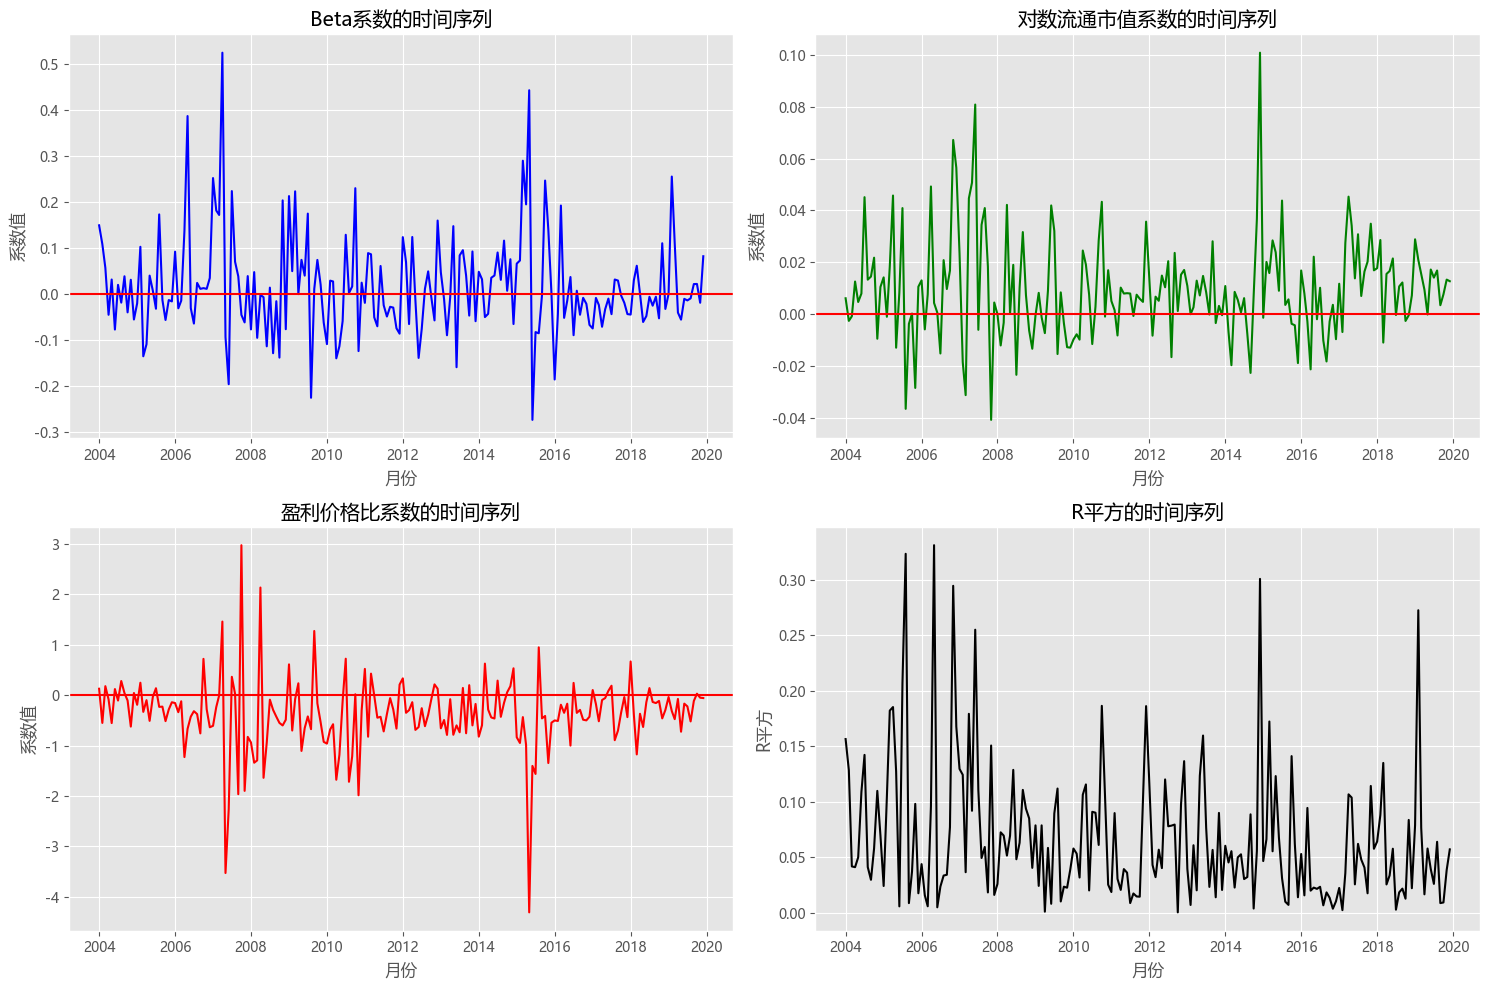


6. 计算系数统计...

系数描述性统计:
              常数项        Beta      对数流通市值       盈利价格比         R平方
count  192.000000  192.000000  192.000000  192.000000  192.000000
mean    -0.201422    0.016485    0.009608   -0.373305    0.067563
std      0.440960    0.108013    0.019390    0.724071    0.061846
min     -2.253650   -0.273176   -0.040740   -4.306693    0.000162
25%     -0.405685   -0.047761   -0.001272   -0.634645    0.022532
50%     -0.165747   -0.002465    0.007953   -0.350386    0.052694
75%      0.066941    0.058427    0.017091   -0.059269    0.092300
max      0.930257    0.525204    0.100805    2.972331    0.331489

年度平均系数:
           常数项      Beta    对数流通市值     盈利价格比       R平方
年份                                                    
2004 -0.232515  0.017090  0.010309 -0.103536  0.081378
2005 -0.089236 -0.005571  0.004653 -0.182247  0.110049
2006 -0.383891  0.048002  0.018738 -0.382795  0.093985
2007 -0.345830  0.092562  0.016784 -0.542400  0.101688
2008 -0.101652 -0.031933  0.004350 -0.53883

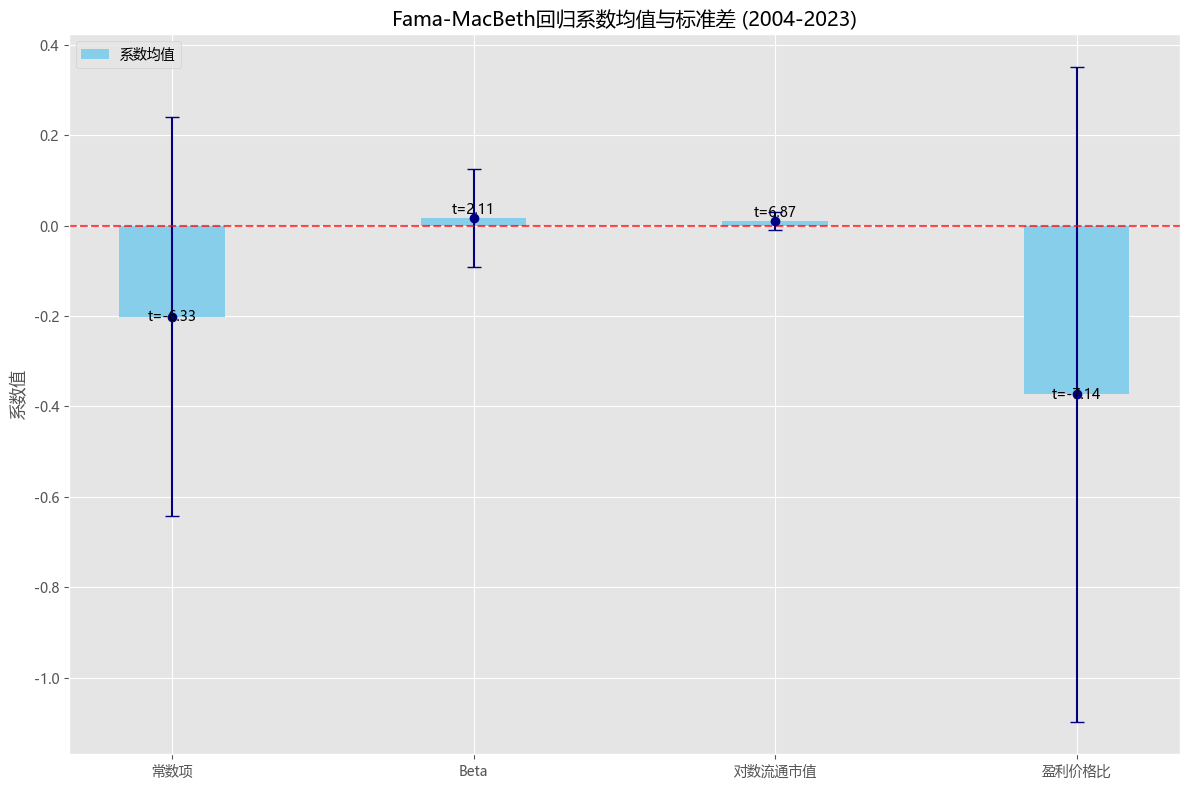

<Figure size 1200x800 with 0 Axes>

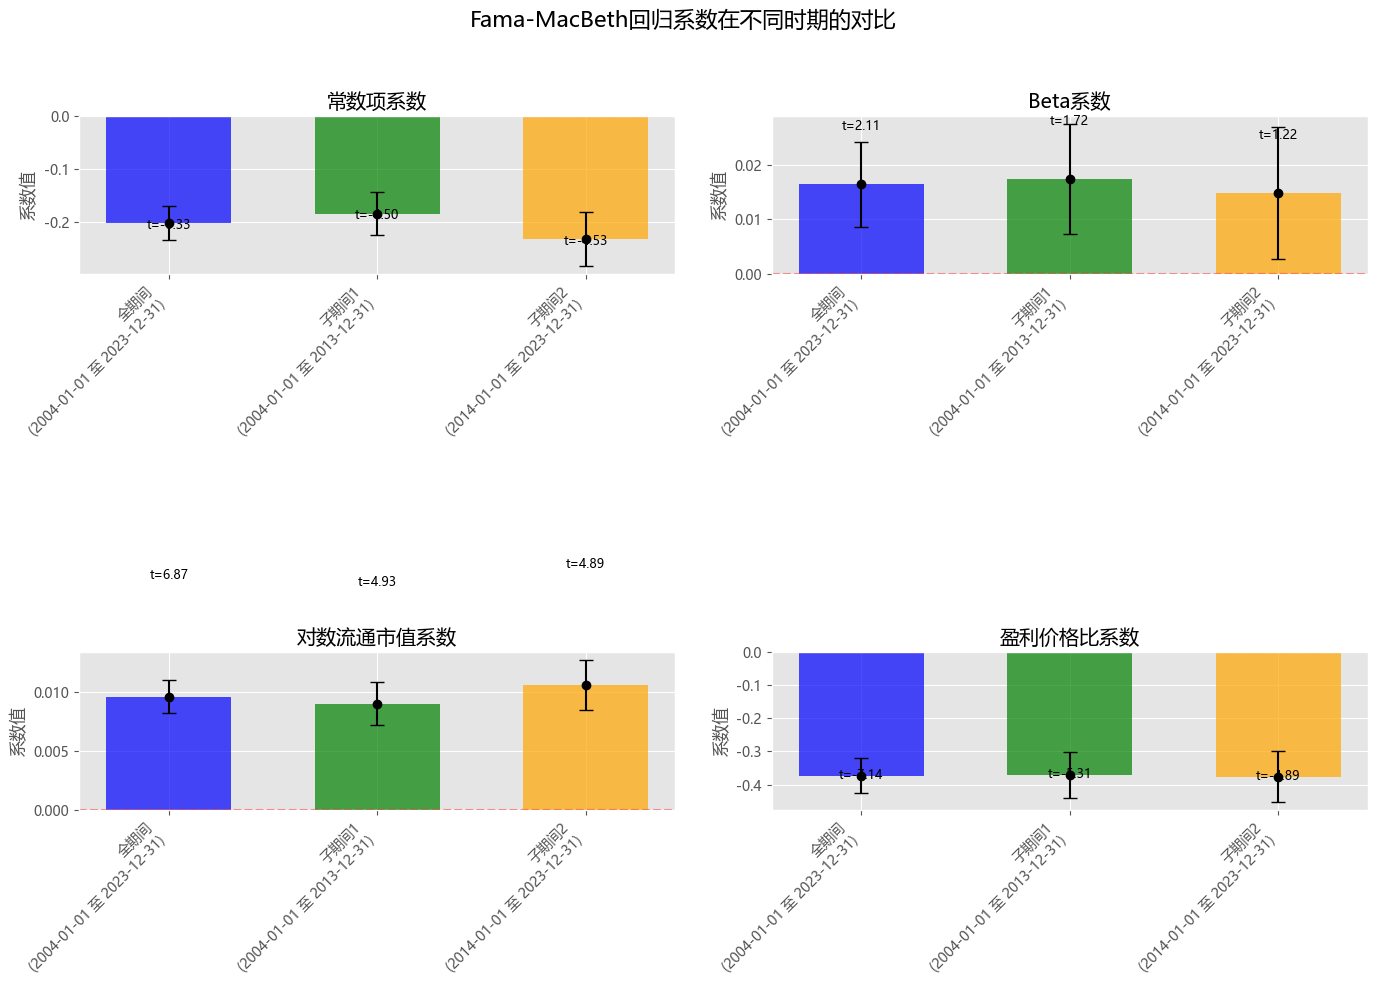

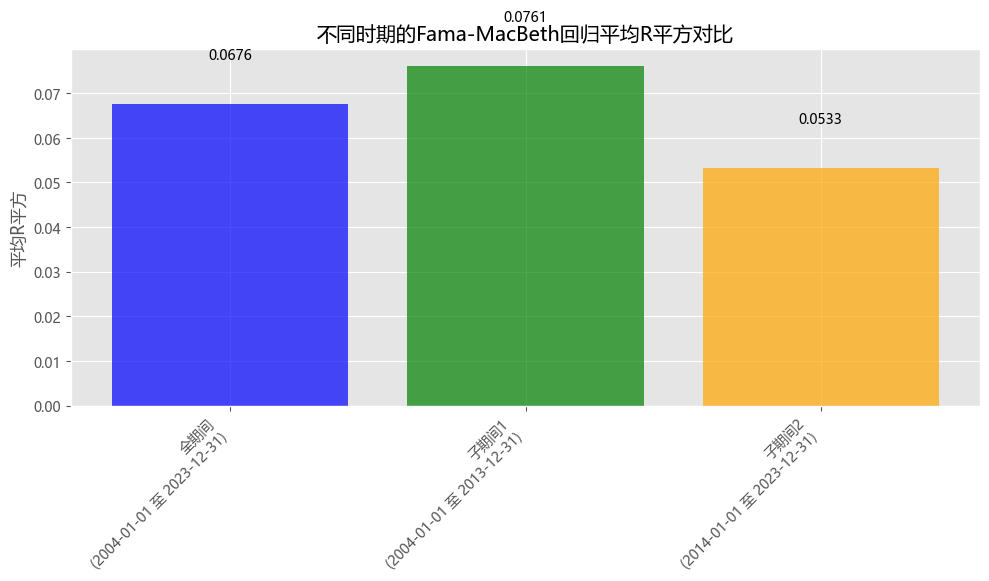

<Figure size 1200x700 with 0 Axes>

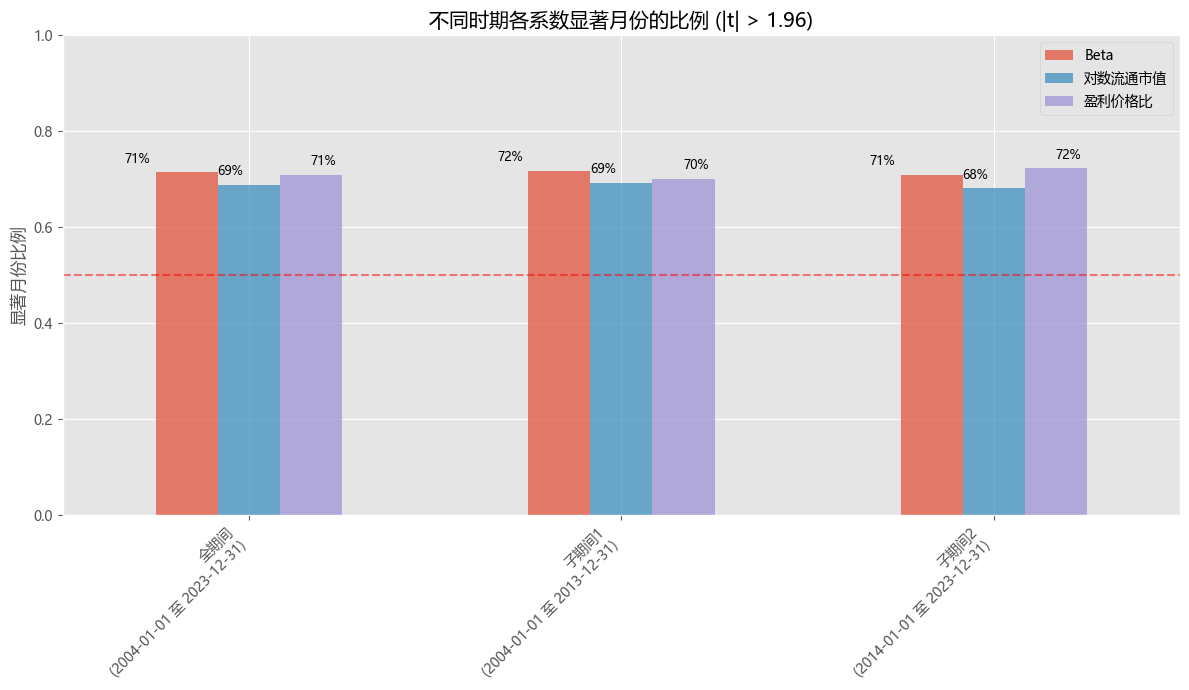

In [30]:
print("================================")
print("中国股市Fama-MacBeth回归分析")
print("研究期间: 2004-2023年")
print("================================")

# 1. 读取数据
print("\n1. 读取数据...")
try:
    df = load_data(data_path='./assets/data/course')
    print(f"数据读取完成，共 {len(df)} 条记录")
except FileNotFoundError:
    # 如果没有找到文件，尝试读取当前目录
    print("未在指定路径找到数据，尝试读取当前目录...")
    df = load_data()
    print(f"数据读取完成，共 {len(df)} 条记录")

# 2. 数据预处理
print("\n2. 数据预处理...")
processed_df = preprocess_data(df)
print(f"预处理完成，共 {len(processed_df)} 条有效记录")

# 2.1 计算或获取Beta值
print("\n2.1 处理Beta值...")
# 首先检查是否已有Beta列
if 'Beta' not in processed_df.columns:
    print("数据中没有Beta列，使用本地数据计算Beta值...")
    processed_df = calculate_beta(processed_df, window=36)  # 使用36个月窗口

print(f"Beta处理完成，Beta值范围: {processed_df['Beta'].min():.2f} 到 {processed_df['Beta'].max():.2f}")

# 3. 执行Fama-MacBeth回归（整体期间和子期间）
print("\n3. 执行Fama-MacBeth回归...")
full_period = '2004-01-01:2023-12-31'
subperiods = ['2004-01-01:2013-12-31', '2014-01-01:2023-12-31']

# 4. 运行完整分析
full_results, subperiod_results = run_fama_macbeth_with_subperiods(
    processed_df, full_period=full_period, subperiods=subperiods)

# 5. 绘制系数时间序列图
print("\n5. 绘制系数时间序列图...")
plot_coefficient_time_series(full_results)

# 6. 系数统计分析
print("\n6. 计算系数统计...")
summary_statistics(full_results)

# 7. 分析结果
print("\n7. 分析结果...")
analyze_fm_results(full_results, subperiod_results, subperiods)

# 8. 增强可视化
print("\n8. 生成增强可视化...")
visualize_results(full_results, subperiod_results, subperiods)